<a href="https://colab.research.google.com/github/bugeki/ML_and_DL_Projects/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Preprocess Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (9,5)
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

from pylab import rcParams

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#pip install mplfinance

In [ ]:
import mplfinance as mpf

In [ ]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


## Loading The Data   (ANSWER 1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv("/content/drive/MyDrive/sample_date_for_challenge.csv")
df.sample(5)

Unnamed: 0             datetime               datetime_est    date_est  time_est     open    high      low    close    volume      vwap  dollar_volume    vwap_est  trend break_bounce
66818       66818  2023-04-26 18:23:00  2023-04-26 14:23:00-04:00  2023-04-26  14:23:00  404.810  405.10  404.785  405.080  316311.0  404.9839   1.281009e+08  406.400079  below     no_break
32209       32209  2023-02-27 21:05:00  2023-02-27 16:05:00-05:00  2023-02-27  16:05:00  397.750  397.84  397.740  397.830   50527.0  397.7694   2.009809e+07  398.722599  below     no_break
79152       79152  2023-05-17 20:25:00  2023-05-17 16:25:00-04:00  2023-05-17  16:25:00  415.230  415.24  415.220  415.220  254489.0  410.3834   1.044381e+08  413.372136  above     no_break
6906         6906  2023-01-13 11:57:00  2023-01-13 06:57:00-05:00  2023-01-13  06:57:00  395.490  395.51  395.460  395.510    2860.0  395.4807   1.131075e+06  396.340294  below     no_break
3958         3958  2023-01-09 20:03:00  2023-01-09 15:03:00-05:00  2023-01-09  15:03:00  388.905  388.98  388.860  388.915  107394.0  388.9101   4.176661e+07  391.460309  below     no_break

The dataset contains 105 days of data, and only workdays are included.




In [ ]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88382 entries, 0 to 88381
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   datetime       88382 non-null  object 
 1   datetime_est   88382 non-null  object 
 2   date_est       88382 non-null  object 
 3   time_est       88382 non-null  object 
 4   open           88382 non-null  float64
 5   high           88382 non-null  float64
 6   low            88382 non-null  float64
 7   close          88382 non-null  float64
 8   volume         88382 non-null  float64
 9   vwap           88382 non-null  float64
 10  dollar_volume  88382 non-null  float64
 11  vwap_est       88382 non-null  float64
 12  trend          88382 non-null  object 
 13  break_bounce   88382 non-null  object 
dtypes: float64(8), object(6)
memory usage: 9.4+ MB


In [ ]:
df.isnull().any().sum()

0

In [ ]:
df.describe().T

count          mean           std           min            25%           50%           75%           max
open           88382.0  4.042871e+02  1.000511e+01    378.030000     396.930000  4.064700e+02  4.120950e+02  4.286800e+02
high           88382.0  4.043605e+02  9.990468e+00    378.220000     396.990000  4.065400e+02  4.121550e+02  4.287400e+02
low            88382.0  4.042130e+02  1.001898e+01    377.831000     396.870000  4.063900e+02  4.120300e+02  4.286401e+02
close          88382.0  4.042872e+02  1.000507e+01    378.030000     396.930000  4.064700e+02  4.120900e+02  4.286900e+02
volume         88382.0  1.003712e+05  2.301098e+05    100.000000    1616.250000  3.376700e+04  1.300938e+05  1.133832e+07
vwap           88382.0  4.042801e+02  1.000505e+01    378.040600     396.923900  4.064626e+02  4.120946e+02  4.286979e+02
dollar_volume  88382.0  4.049613e+07  9.272313e+07  37956.000000  653615.138325  1.356247e+07  5.268234e+07  4.467460e+09
vwap_est       88382.0  4.041665e+02  9.929369e+00    379.298462     396.817787  4.061593e+02  4.118810e+02  4.268079e+02

The dataset appears to be free of outliers.

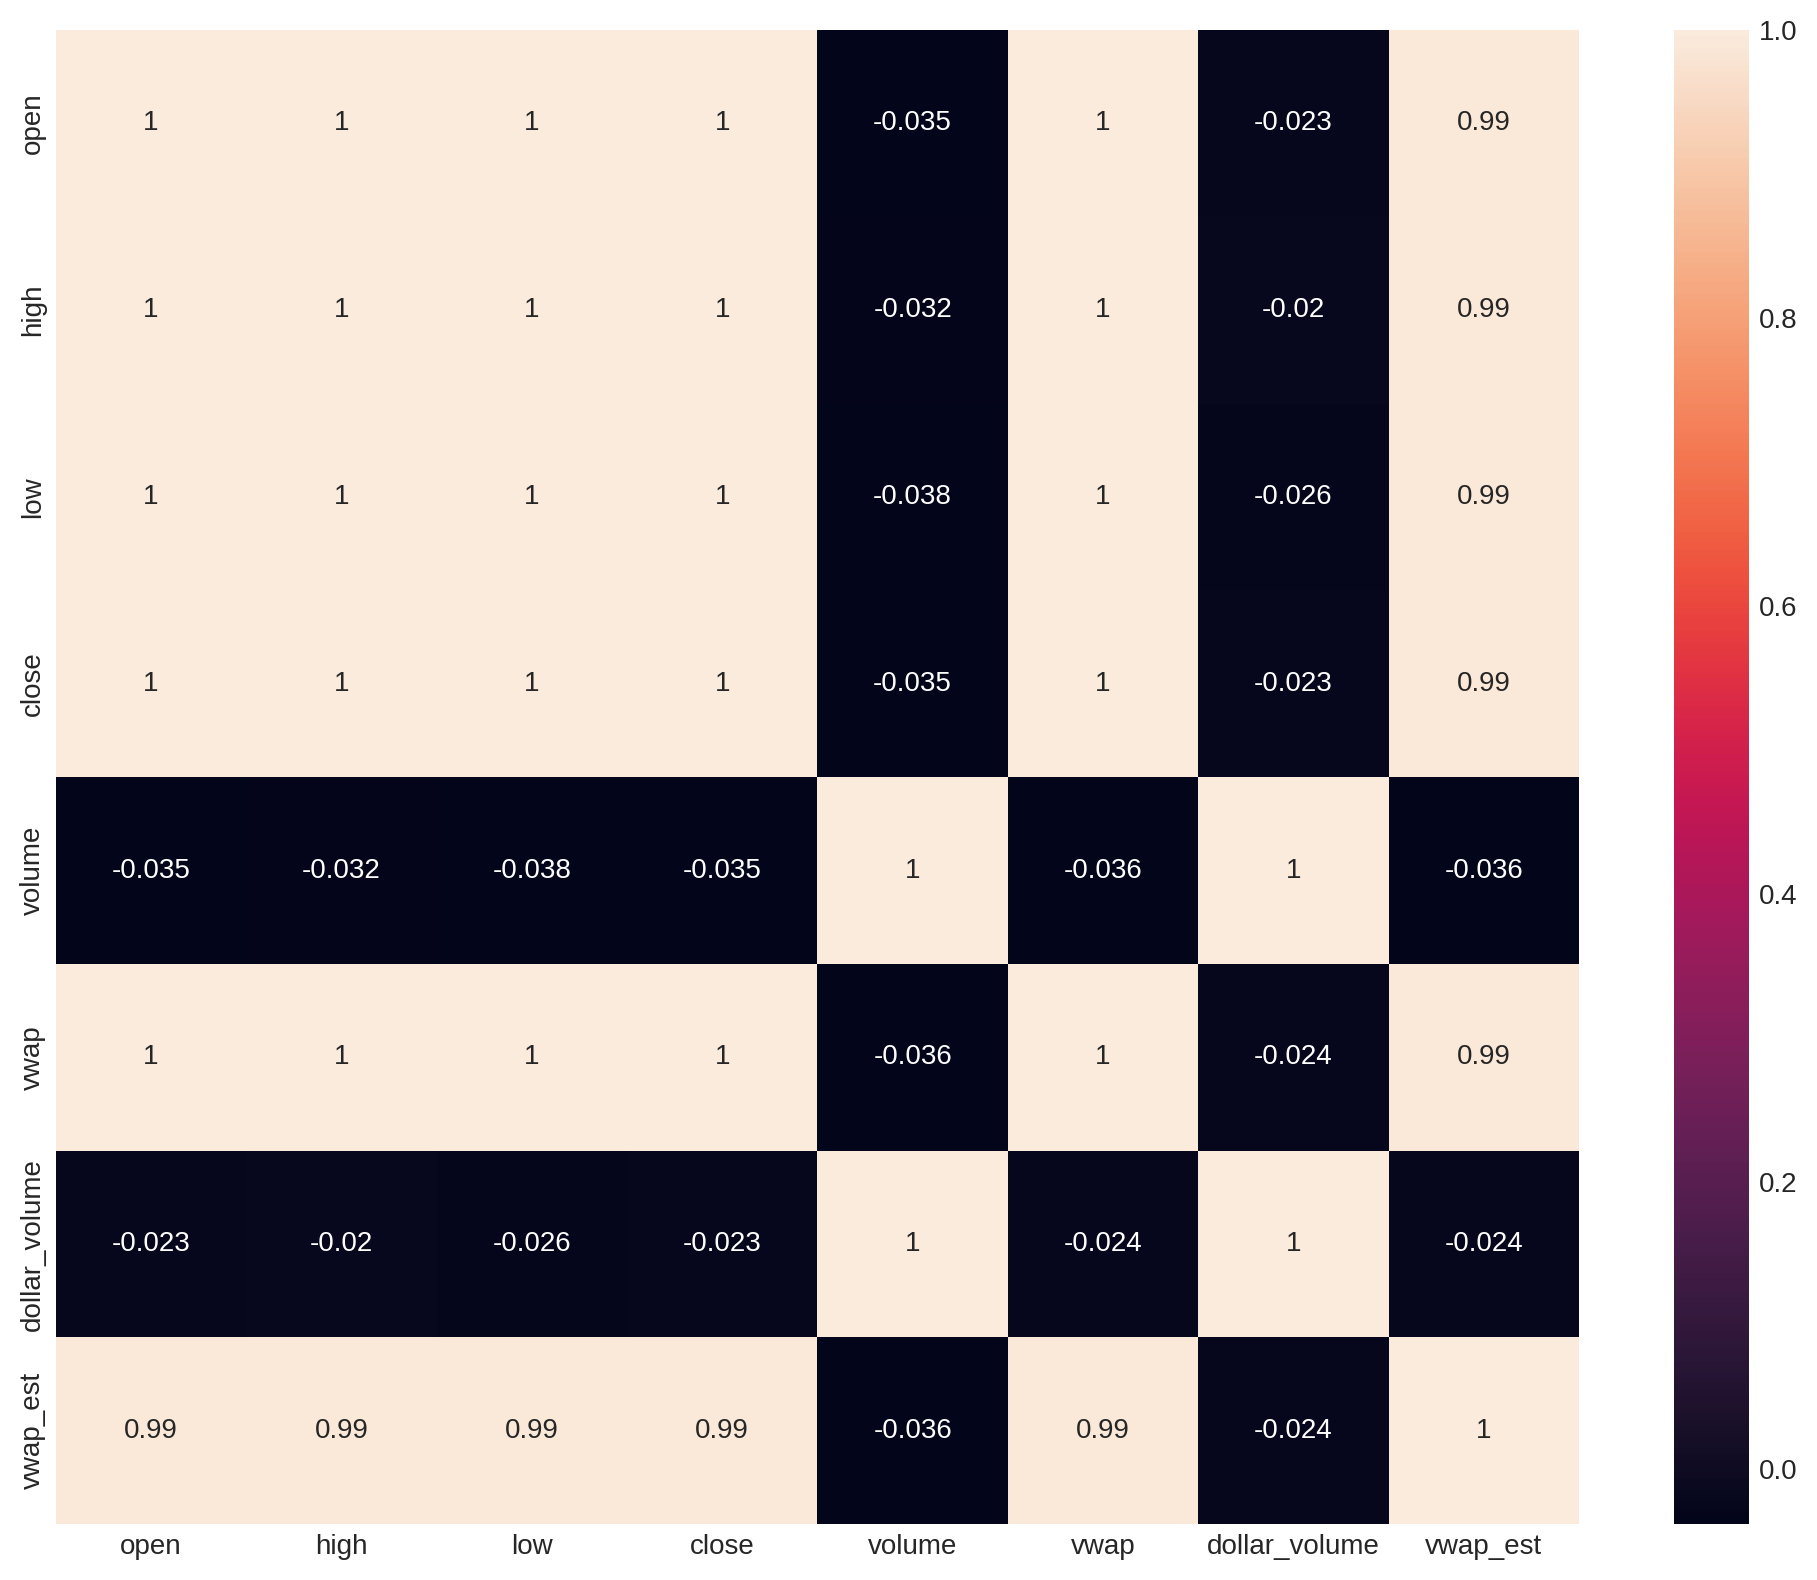

In [ ]:
plt.figure(figsize=(10, 8)) 
sns.heatmap(df.corr(), annot=True)
plt.show()

In [ ]:
# Convert the datetime column to datetime type
df['datetime'] = pd.to_datetime(df['datetime'])

# Filter the data for the specified interval
start_time = pd.Timestamp('2023-05-24 09:30:00')
end_time = pd.Timestamp('2023-05-24 11:00:00')
filtered_df = df[(df['datetime'] >= start_time) & (df['datetime'] <= end_time)]

In [ ]:
filtered_df = filtered_df[['datetime', 'open', 'high', 'low', 'close', 'volume', 'vwap','vwap_est']]


In [ ]:
filtered_df


datetime    open    high     low   close   volume      vwap    vwap_est
82619 2023-05-24 09:30:00  413.51  413.51  413.51  413.51    100.0  413.5100  413.546297
82620 2023-05-24 09:31:00  413.50  413.50  413.50  413.50    597.0  413.4988  413.545911
82621 2023-05-24 09:33:00  413.52  413.52  413.45  413.45    233.0  413.4833  413.545713
82622 2023-05-24 09:38:00  413.42  413.43  413.33  413.43   4563.0  413.3925  413.536783
82623 2023-05-24 09:39:00  413.42  413.43  413.42  413.42    960.0  413.4213  413.535384
82624 2023-05-24 09:41:00  413.44  413.46  413.44  413.46    635.0  413.4553  413.534747
82625 2023-05-24 09:42:00  413.55  413.56  413.54  413.54    654.0  413.5487  413.534860
82626 2023-05-24 09:48:00  413.44  413.44  413.44  413.44    227.0  413.4400  413.534594
82627 2023-05-24 09:50:00  413.39  413.40  413.38  413.40  20227.0  413.3987  413.507375
82628 2023-05-24 09:51:00  413.39  413.39  413.37  413.39   6605.0  413.3858  413.499912
82629 2023-05-24 09:52:00  413.41  413.45  413.39  413.45  13401.0  413.4251  413.491626
82630 2023-05-24 09:53:00  413.50  413.50  413.48  413.50  13603.0  413.4973  413.492199
82631 2023-05-24 09:54:00  413.47  413.51  413.47  413.51  27112.0  413.5049  413.494329
82632 2023-05-24 09:55:00  413.47  413.51  413.47  413.51  20500.0  413.4979  413.494730
82633 2023-05-24 09:56:00  413.47  413.47  413.47  413.47    331.0  413.4852  413.494713
82634 2023-05-24 09:59:00  413.36  413.36  413.36  413.36    296.0  413.3688  413.494509
82635 2023-05-24 10:00:00  413.34  413.34  413.34  413.34    678.0  413.3401  413.493939
82636 2023-05-24 10:01:00  413.33  413.33  413.26  413.26   3004.0  413.3296  413.491292
82637 2023-05-24 10:02:00  413.50  413.58  413.49  413.49   6103.0  413.5281  413.492458
82638 2023-05-24 10:03:00  413.50  413.50  413.50  413.50   1200.0  413.5000  413.492505
82639 2023-05-24 10:04:00  413.59  413.60  413.59  413.59   2000.0  413.5940  413.493542
82640 2023-05-24 10:05:00  413.47  413.47  413.33  413.33    729.0  413.4152  413.493251
82641 2023-05-24 10:06:00  413.33  413.33  413.31  413.31   1011.0  413.3221  413.492375
82642 2023-05-24 10:07:00  413.20  413.20  413.16  413.16    809.0  413.1848  413.491121
82643 2023-05-24 10:09:00  413.21  413.21  413.17  413.17    568.0  413.1917  413.490266
82644 2023-05-24 10:10:00  413.00  413.00  412.91  412.91   1836.0  412.9503  413.485328
82645 2023-05-24 10:11:00  413.00  413.00  412.96  412.99   1395.0  412.9784  413.481830
82646 2023-05-24 10:12:00  412.95  412.95  412.95  412.95   1105.0  412.9481  413.478929
82647 2023-05-24 10:13:00  412.95  412.95  412.95  412.95    154.0  412.9465  413.478526
82648 2023-05-24 10:14:00  412.95  412.95  412.95  412.95    159.0  412.9517  413.478114
82649 2023-05-24 10:15:00  412.82  412.82  412.80  412.80   1335.0  412.8122  413.473776
82650 2023-05-24 10:16:00  412.85  412.85  412.84  412.84   4047.0  412.8479  413.461655
82651 2023-05-24 10:17:00  412.80  412.80  412.80  412.80    518.0  412.8022  413.460024
82652 2023-05-24 10:18:00  412.70  412.93  412.70  412.93   2445.0  412.7341  413.451649
82653 2023-05-24 10:19:00  412.86  412.86  412.86  412.86    332.0  412.8686  413.450737
82654 2023-05-24 10:20:00  412.81  412.81  412.81  412.81    172.0  412.8109  413.450219
82655 2023-05-24 10:22:00  412.74  412.74  412.65  412.65    922.0  412.6828  413.446903
82656 2023-05-24 10:23:00  412.65  412.65  412.64  412.64    910.0  412.6466  413.443504
82657 2023-05-24 10:24:00  412.70  412.70  412.70  412.70    174.0  412.6982  413.442899
82658 2023-05-24 10:25:00  412.70  412.71  412.70  412.71    863.0  412.7049  413.439941
82659 2023-05-24 10:26:00  412.74  412.74  412.74  412.74    457.0  412.7460  413.438472
82660 2023-05-24 10:27:00  412.79  412.79  412.77  412.77   1300.0  412.7805  413.434531
82661 2023-05-24 10:28:00  412.74  412.74  412.74  412.74    203.0  412.7399  413.433882
82662 2023-05-24 10:29:00  412.59  412.70  412.59  412.68   1043.0  412.6513  413.430143
82663 2023-0

In [ ]:
filtered_df.set_index('datetime', inplace=True)


In [ ]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70 entries, 2023-05-24 09:30:00 to 2023-05-24 11:00:00
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      70 non-null     float64
 1   high      70 non-null     float64
 2   low       70 non-null     float64
 3   close     70 non-null     float64
 4   volume    70 non-null     float64
 5   vwap      70 non-null     float64
 6   vwap_est  70 non-null     float64
dtypes: float64(7)
memory usage: 4.4 KB


## Candle Sticks and VWAP 

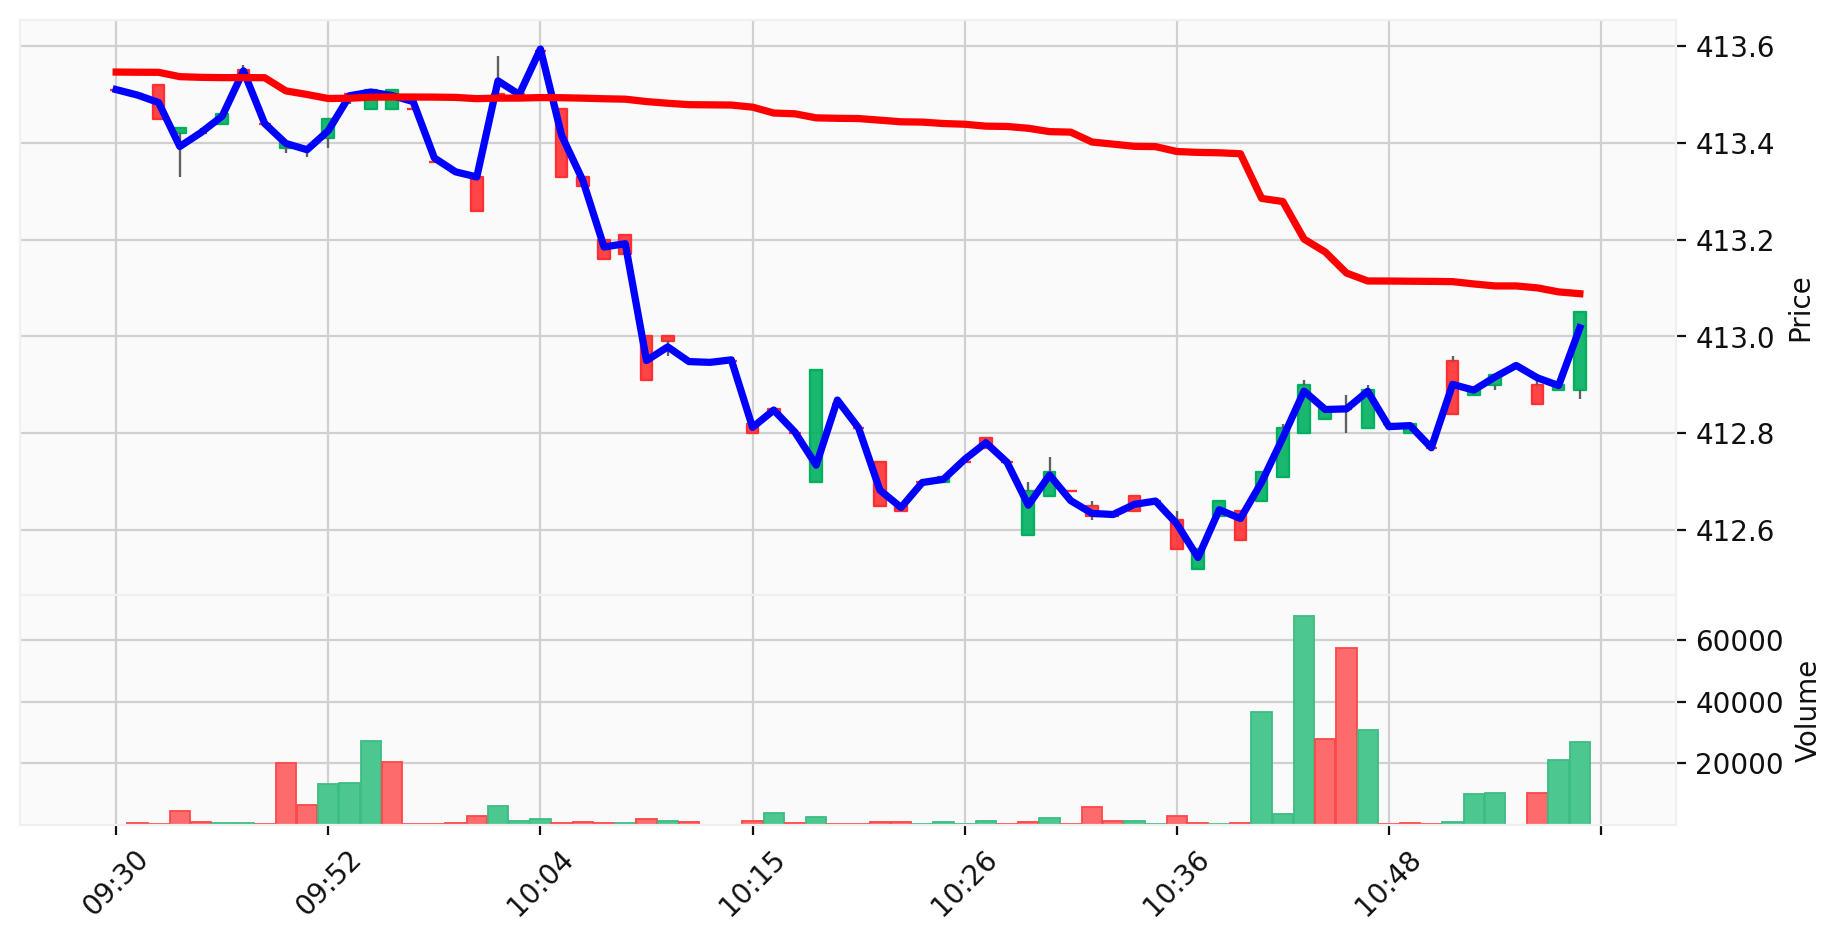

In [ ]:
# Create addplot objects for 'vwap' and 'vwap_est' lines
adp = mpf.make_addplot(filtered_df['vwap'], type='line', color='blue' )
adp1 = mpf.make_addplot(filtered_df['vwap_est'], type='line', color='red')

# Plot candlestick chart with 'vwap' and 'vwap_est' overlays
mpf.plot(filtered_df, type='candle', addplot=[adp, adp1], volume=True, style='yahoo', figratio=(8, 4))


### 5 Min Intervals of Candle Sticks Along With  The vwap_est   (ANSWER 2)

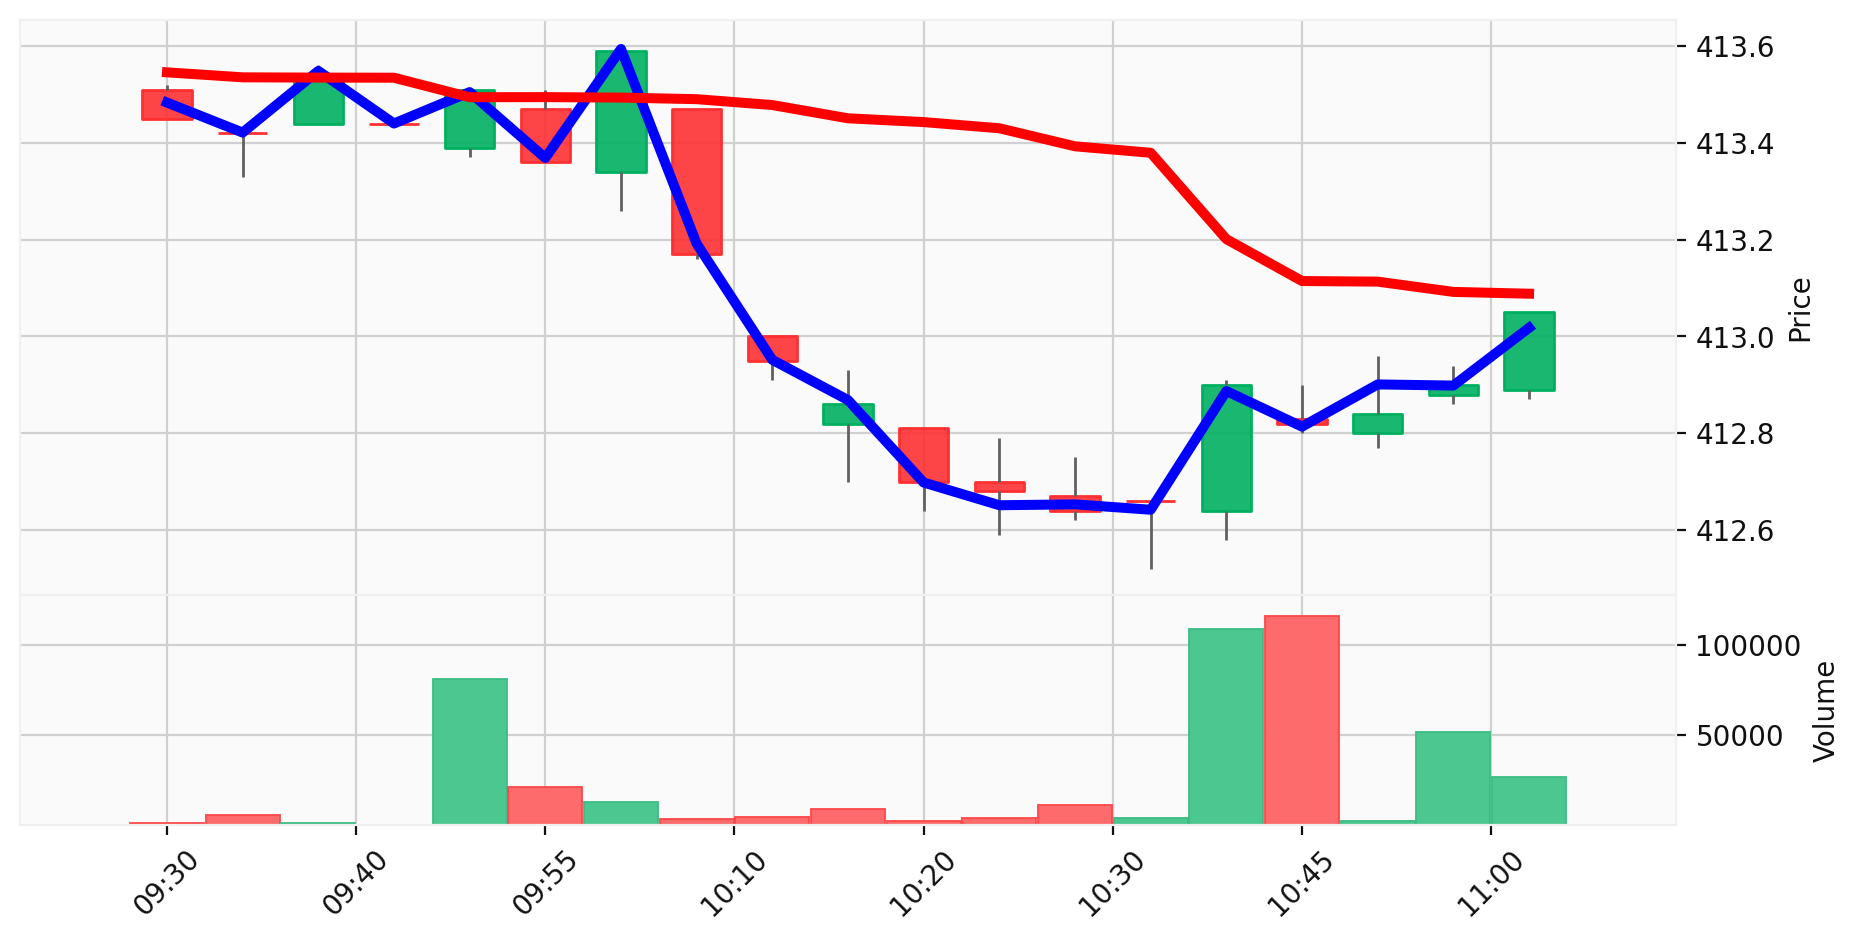

In [ ]:

# Resample the DataFrame to 5-minute intervals
resampled_df = filtered_df.resample('5Min').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
    'vwap': 'last',
    'vwap_est': 'last'
})

# Create addplot objects for 'vwap' and 'vwap_est' lines
adp = mpf.make_addplot(resampled_df['vwap'], type='line', color='blue')
adp1 = mpf.make_addplot(resampled_df['vwap_est'], type='line', color='red')

# Plot candlestick chart with 'vwap' and 'vwap_est' overlays
mpf.plot(resampled_df, type='candle', addplot=[adp, adp1], volume=True, style='yahoo', figratio=(8, 4))


## Lagged features of price and volume (1 to 5 minutes)   (ANSWER 3)

In [ ]:
lags = range(1, 6)  # lagged features (1 to 5 minutes)

# Add lagged price features
for lag in lags:
    df[f'lag_price_{lag}'] = df['close'].shift(lag)

# Add lagged volume features
for lag in lags:
    df[f'lag_volume_{lag}'] = df['volume'].shift(lag)


In [ ]:
df.dropna(inplace=True)

The first 5 rows of data (NaN values which comes from adding lagged features) are removed.

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88377 entries, 0 to 88376
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       88377 non-null  datetime64[ns]
 1   datetime_est   88377 non-null  object        
 2   date_est       88377 non-null  object        
 3   time_est       88377 non-null  object        
 4   open           88377 non-null  float64       
 5   high           88377 non-null  float64       
 6   low            88377 non-null  float64       
 7   close          88377 non-null  float64       
 8   volume         88377 non-null  float64       
 9   vwap           88377 non-null  float64       
 10  dollar_volume  88377 non-null  float64       
 11  vwap_est       88377 non-null  float64       
 12  trend          88377 non-null  object        
 13  break_bounce   88377 non-null  object        
 14  lag_price_1    88377 non-null  float64       
 15  lag_price_2    8837

### Visualizing using Lag Plots

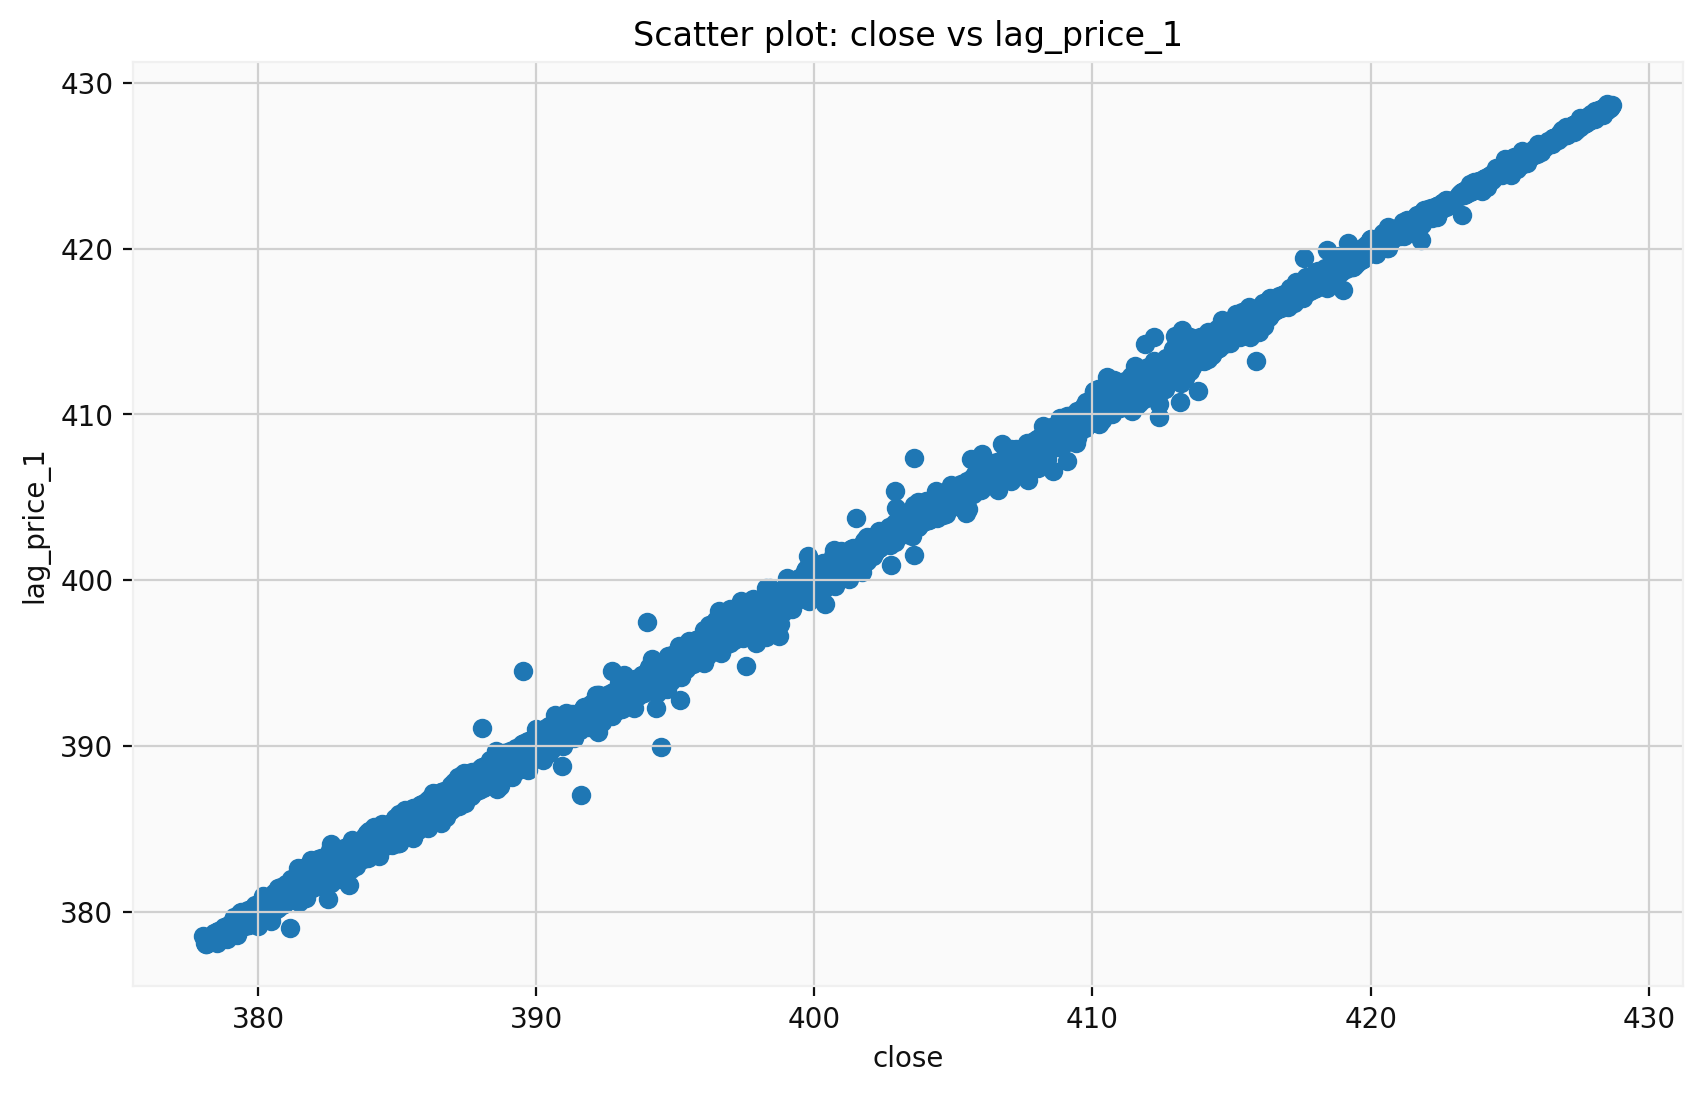

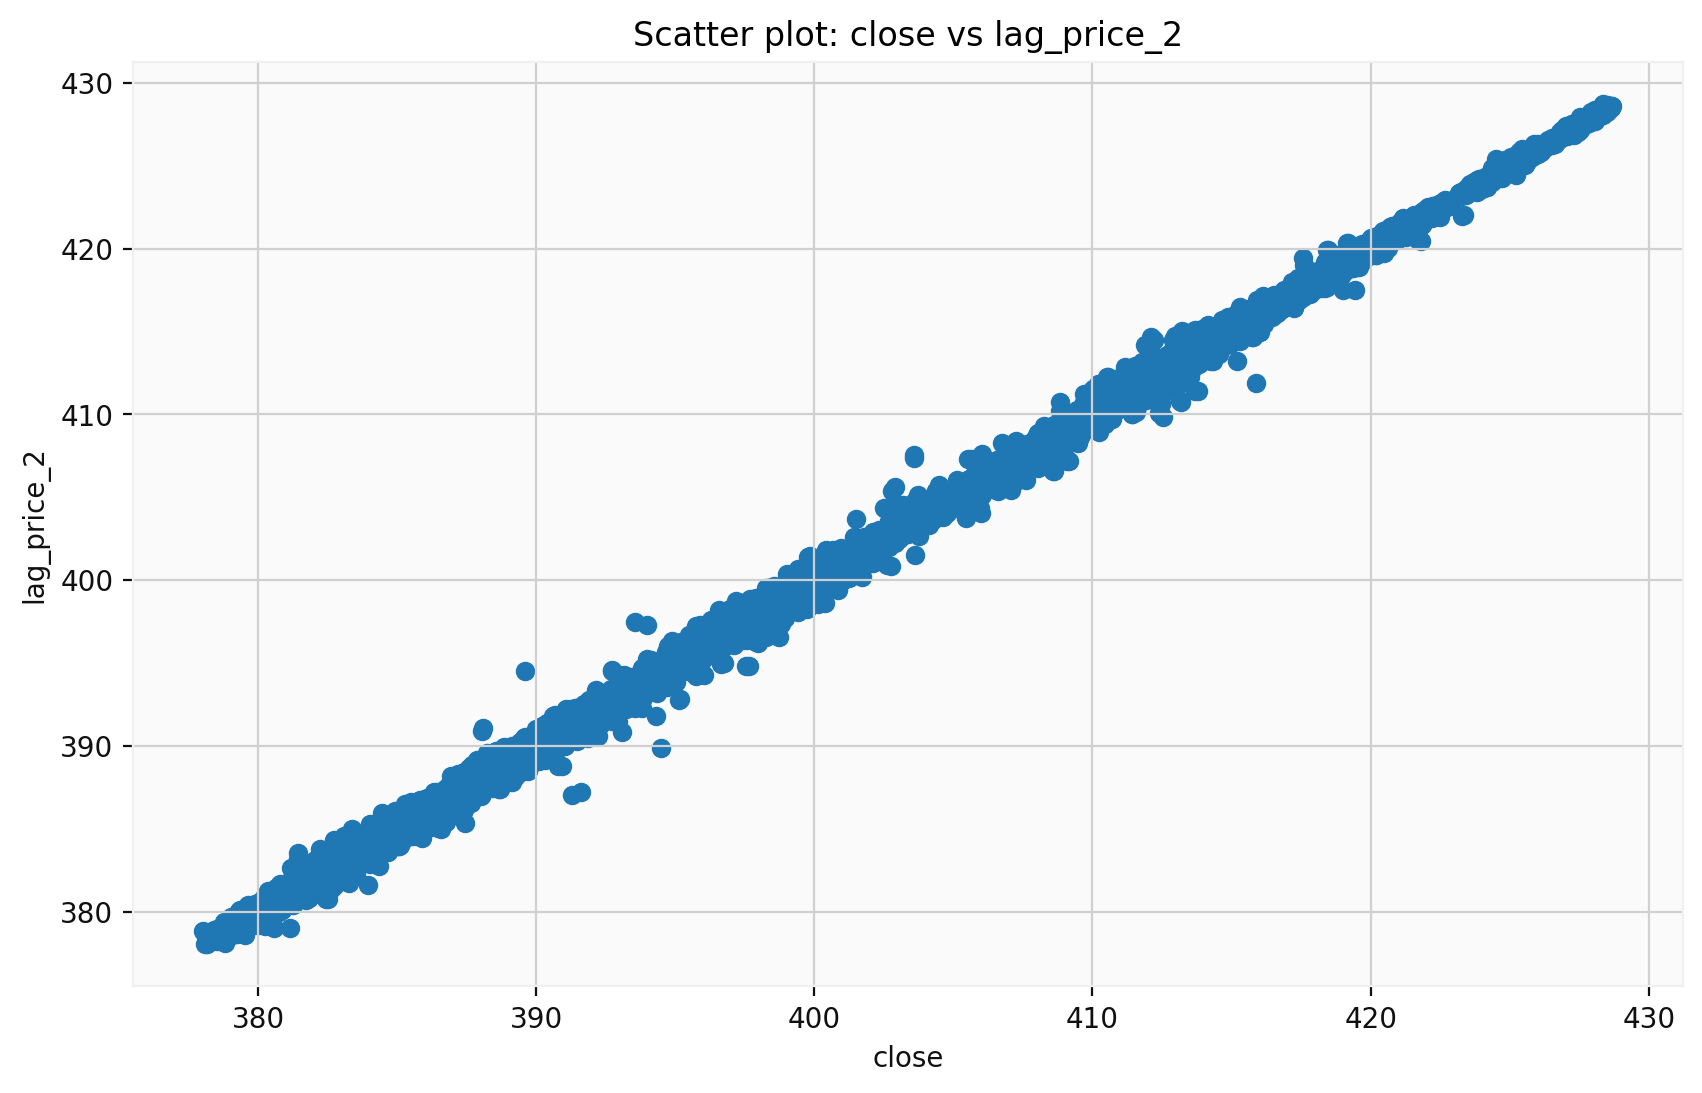

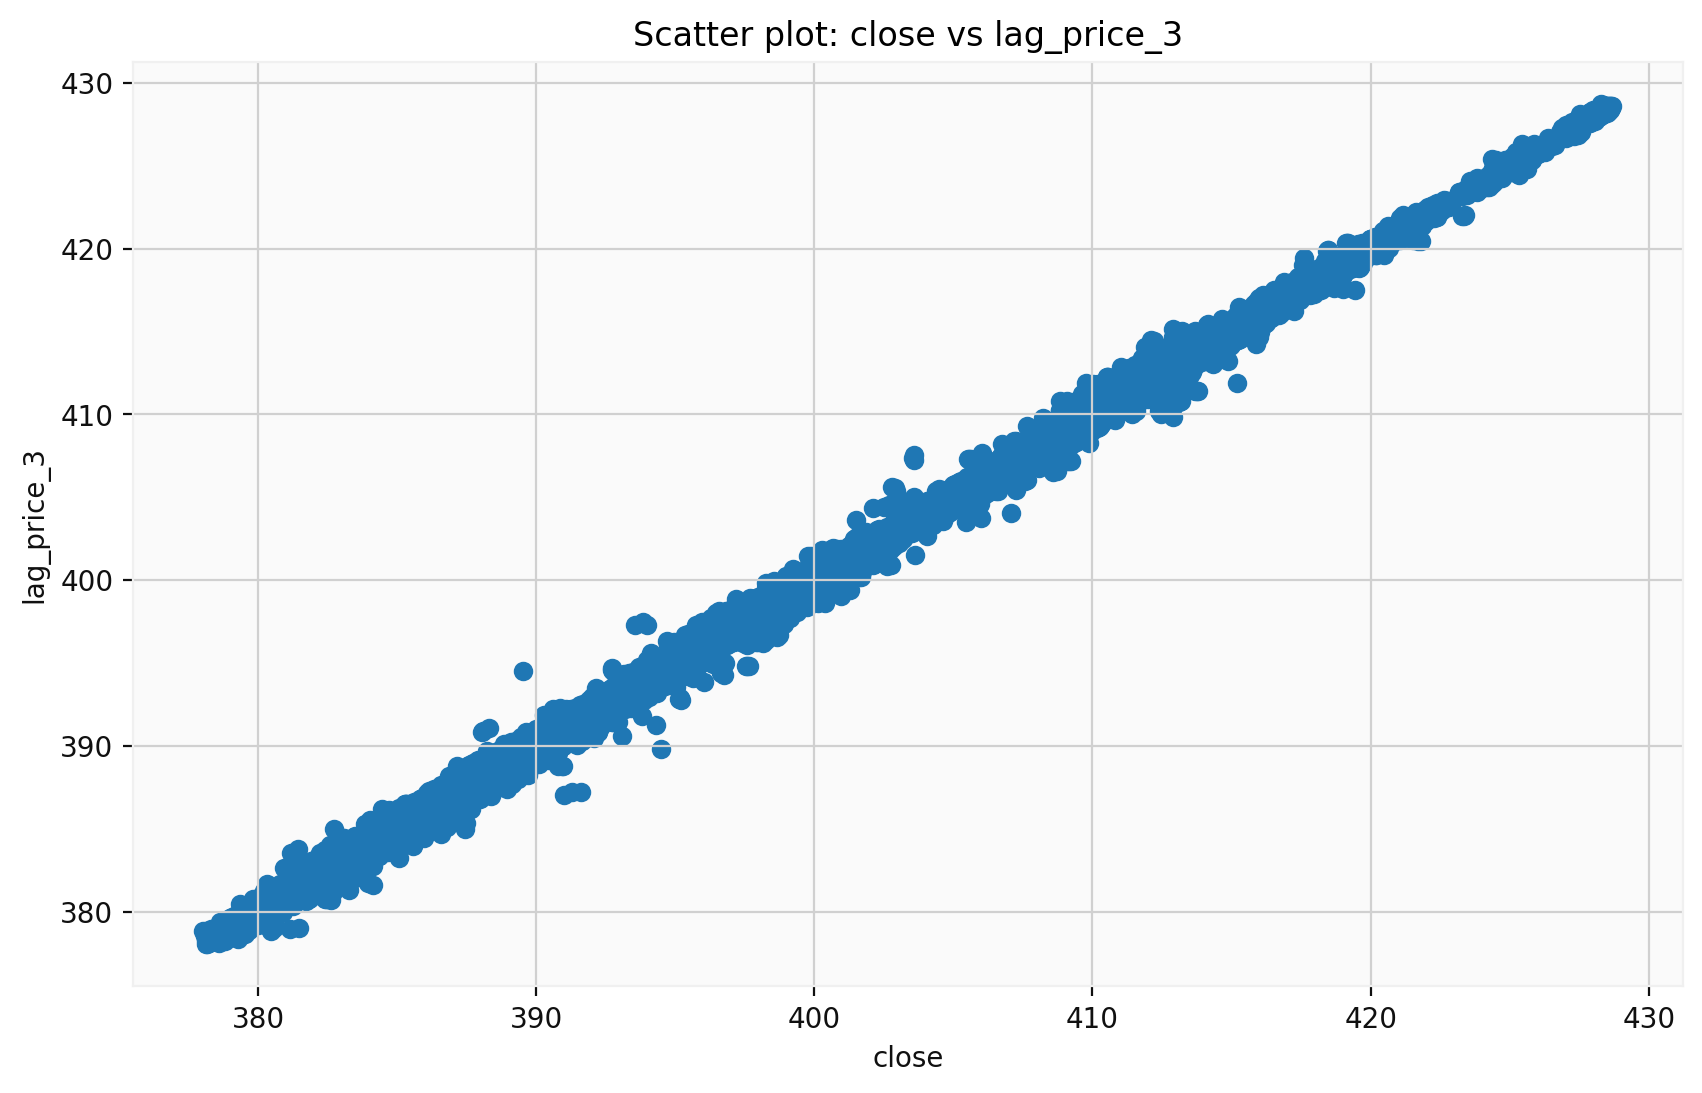

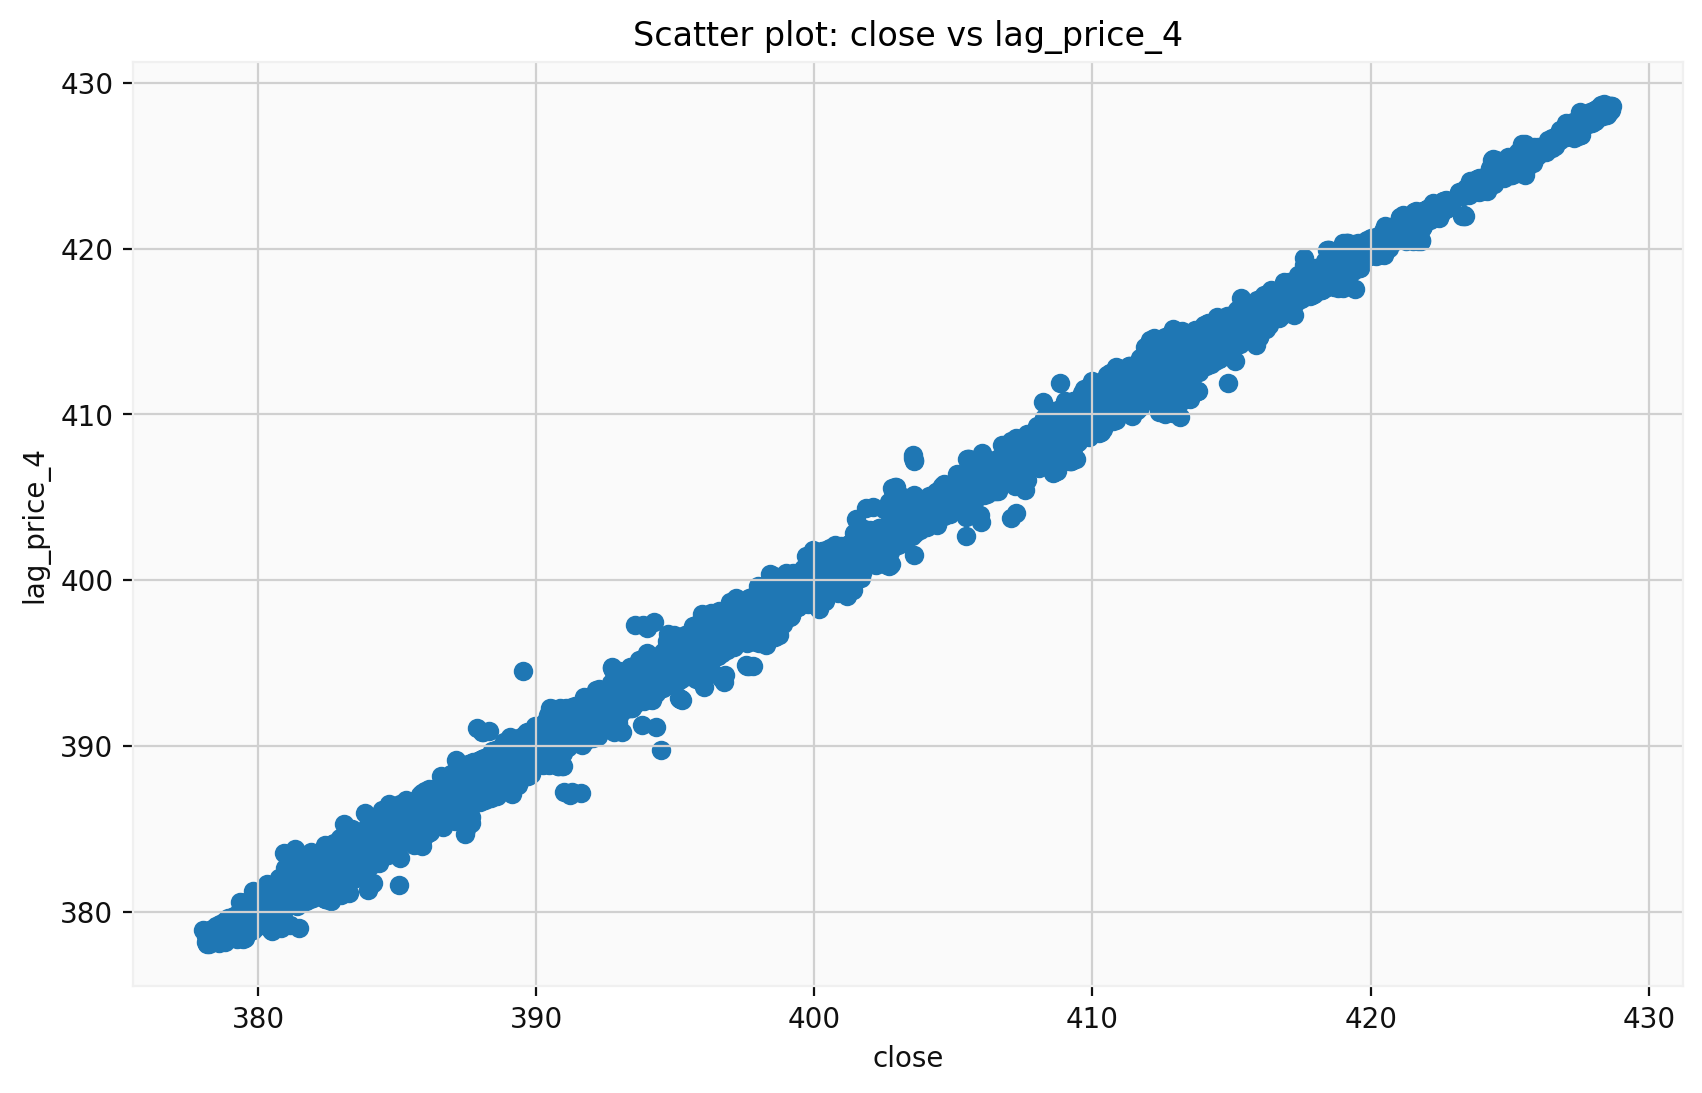

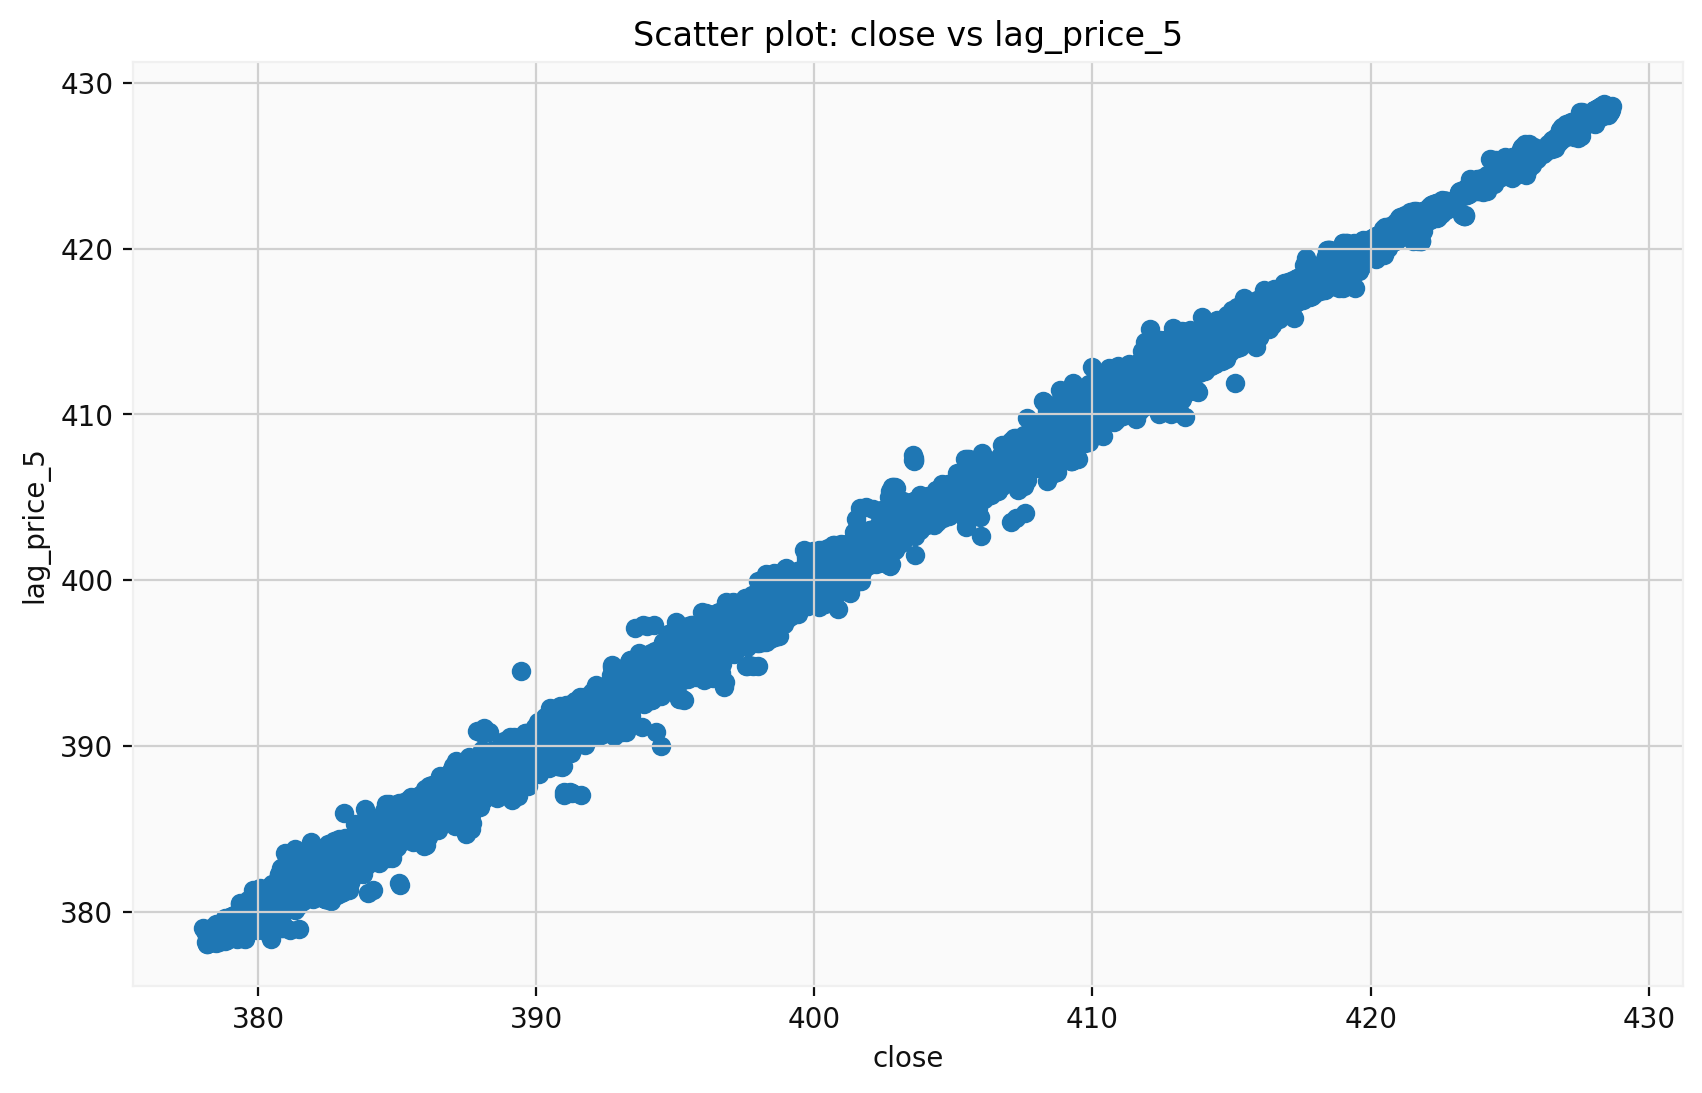

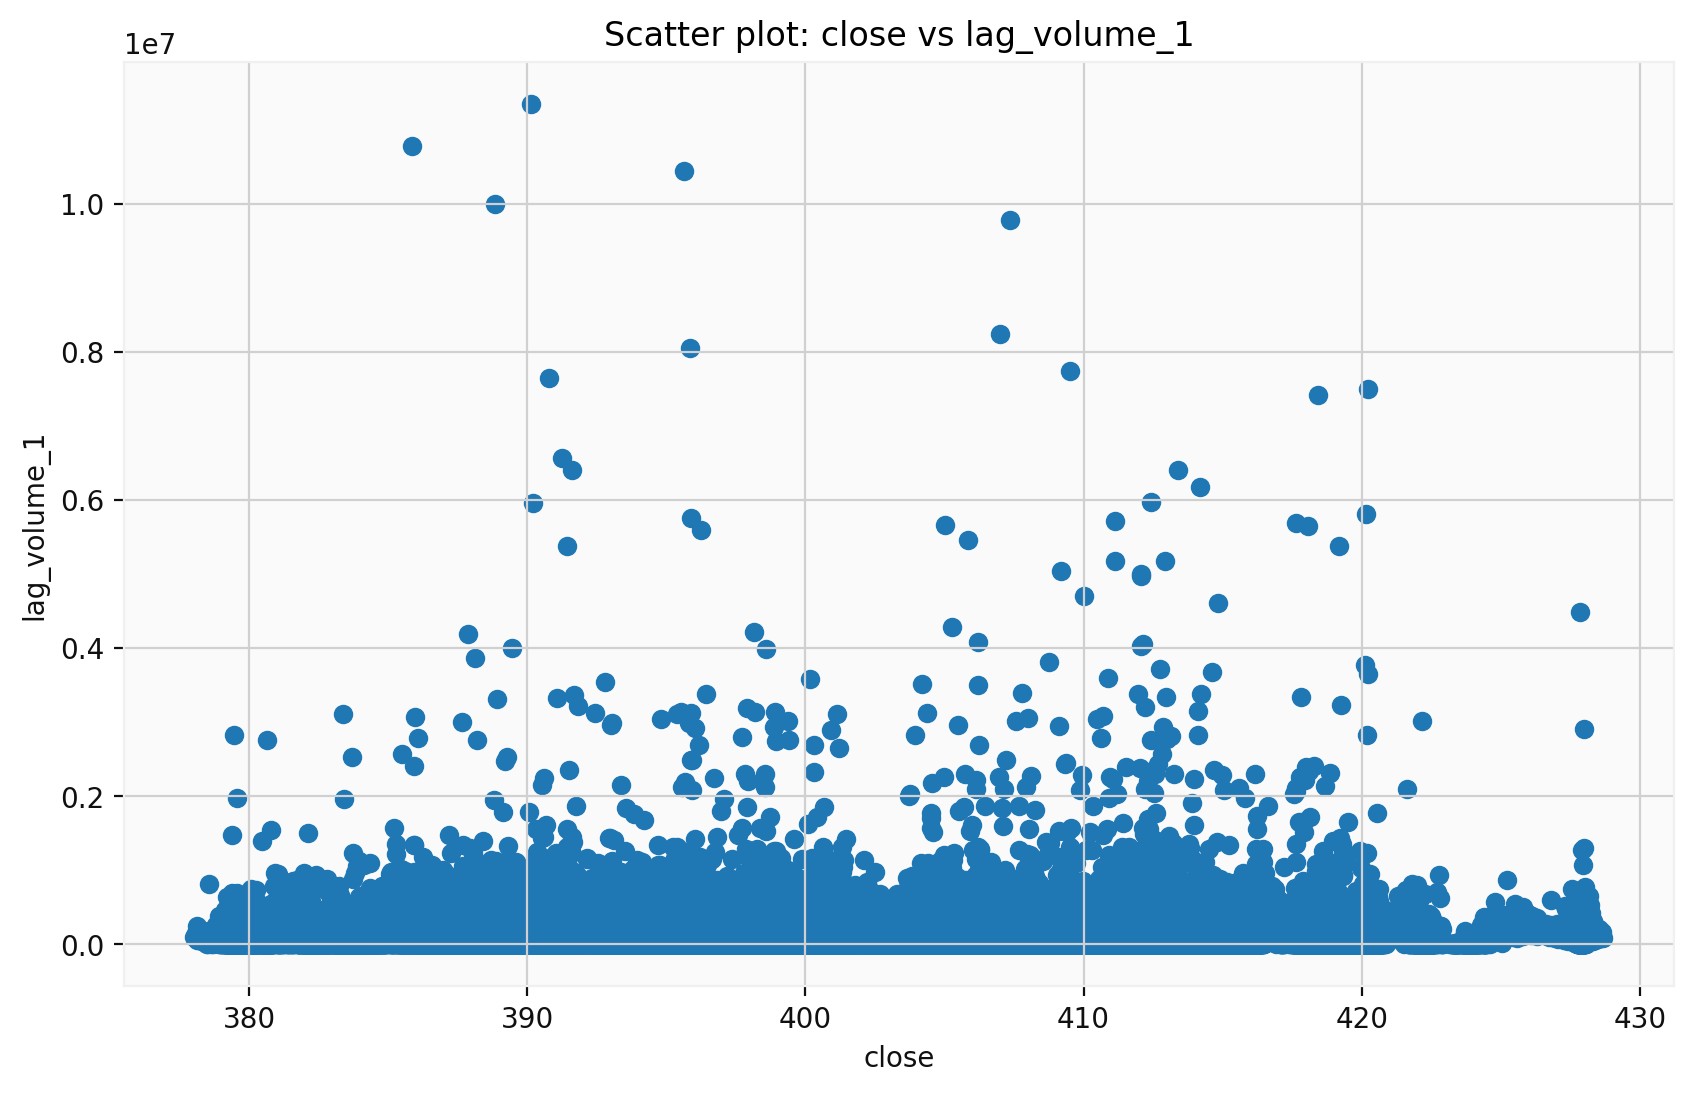

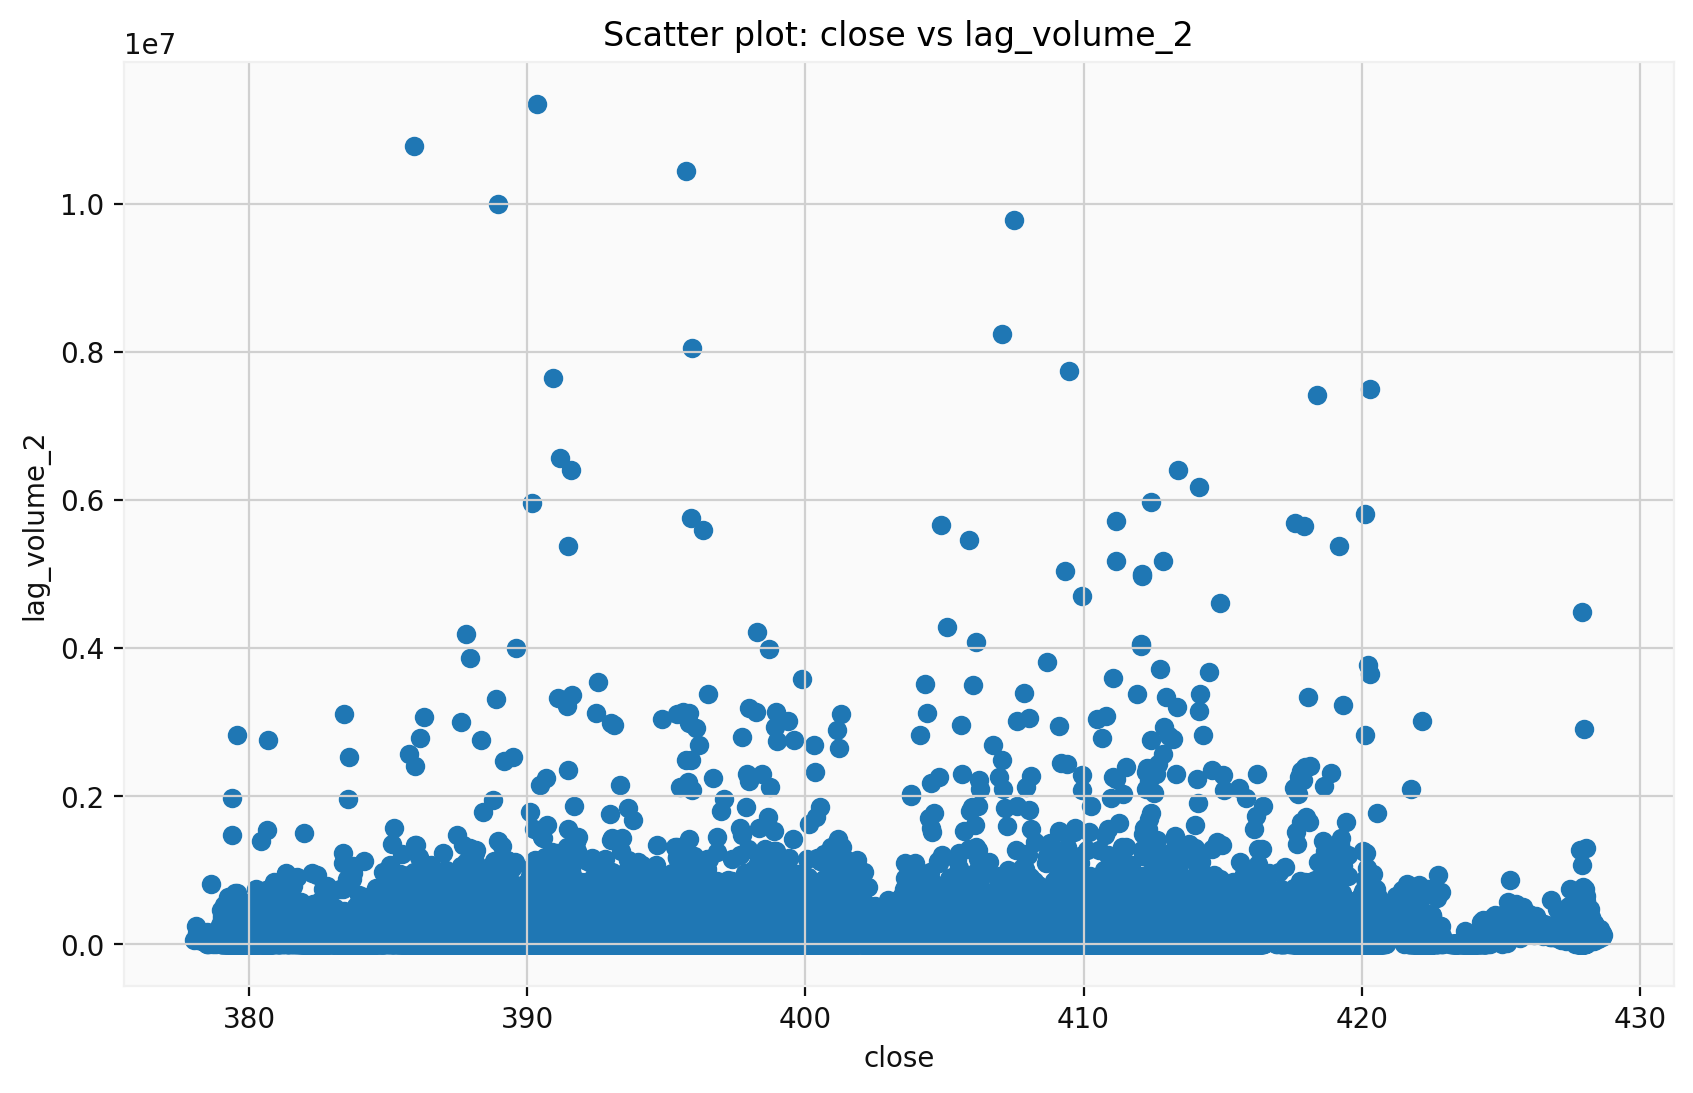

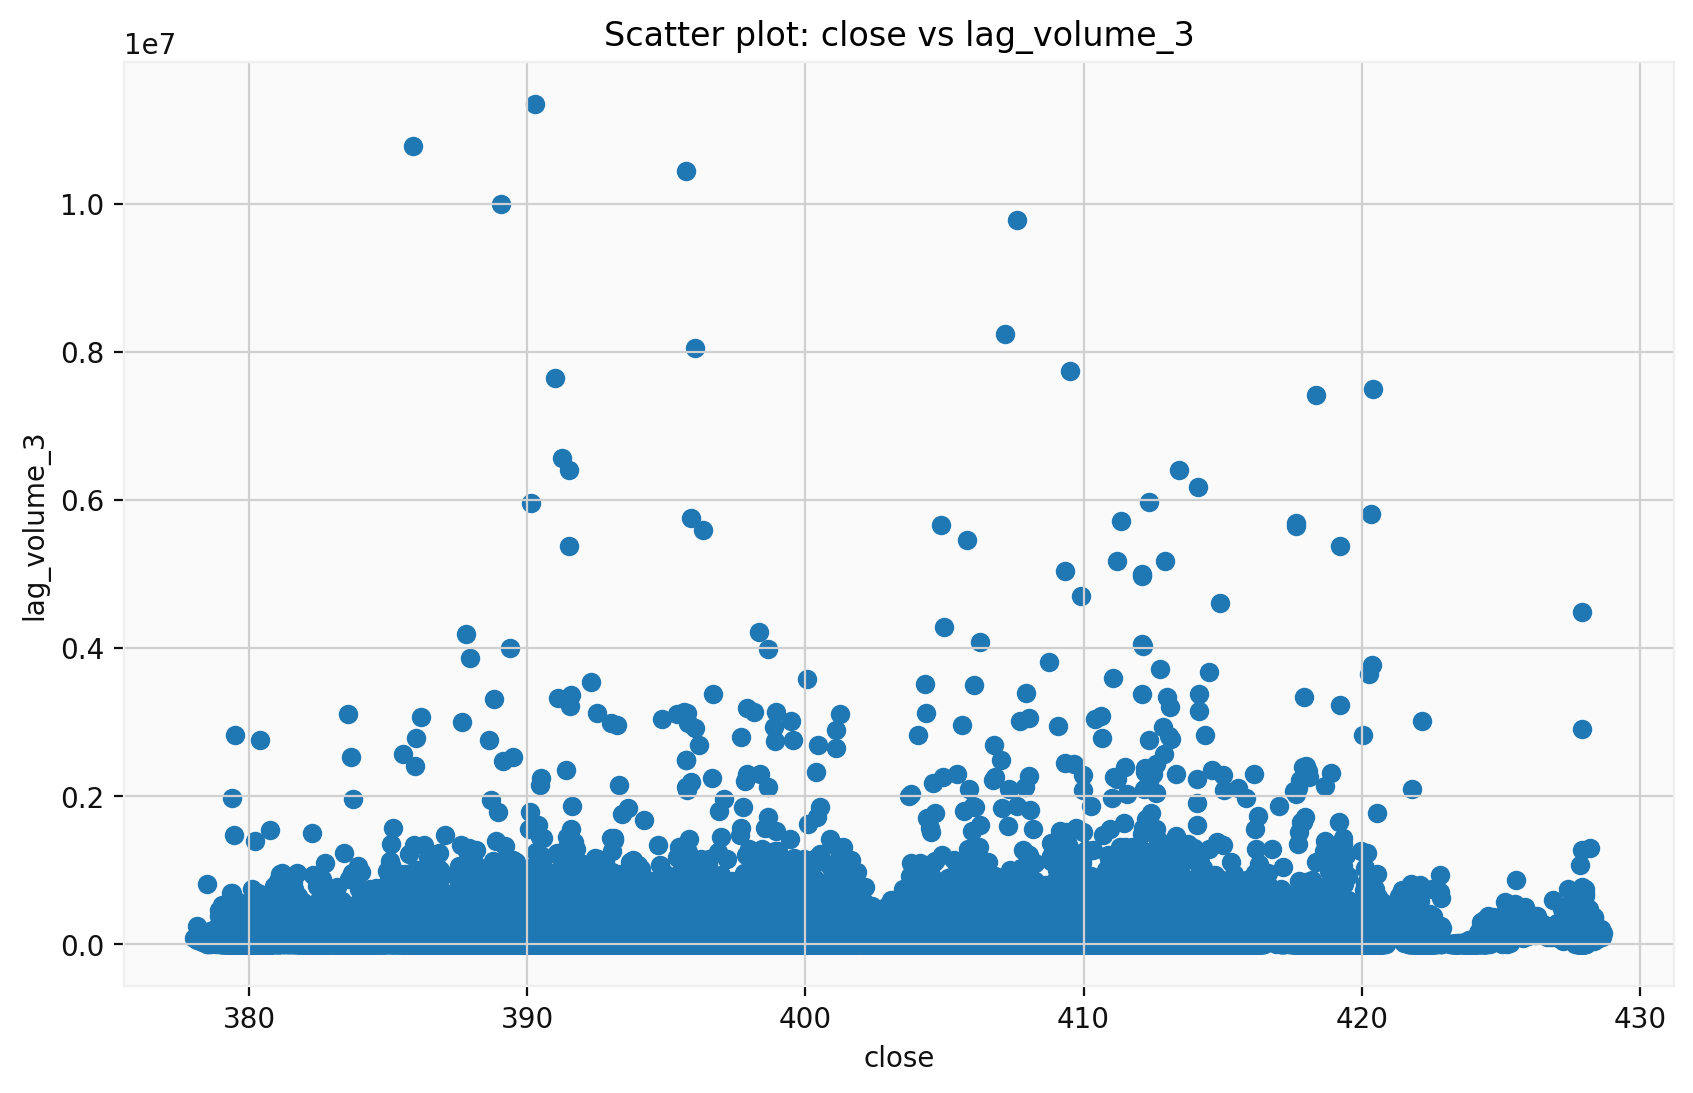

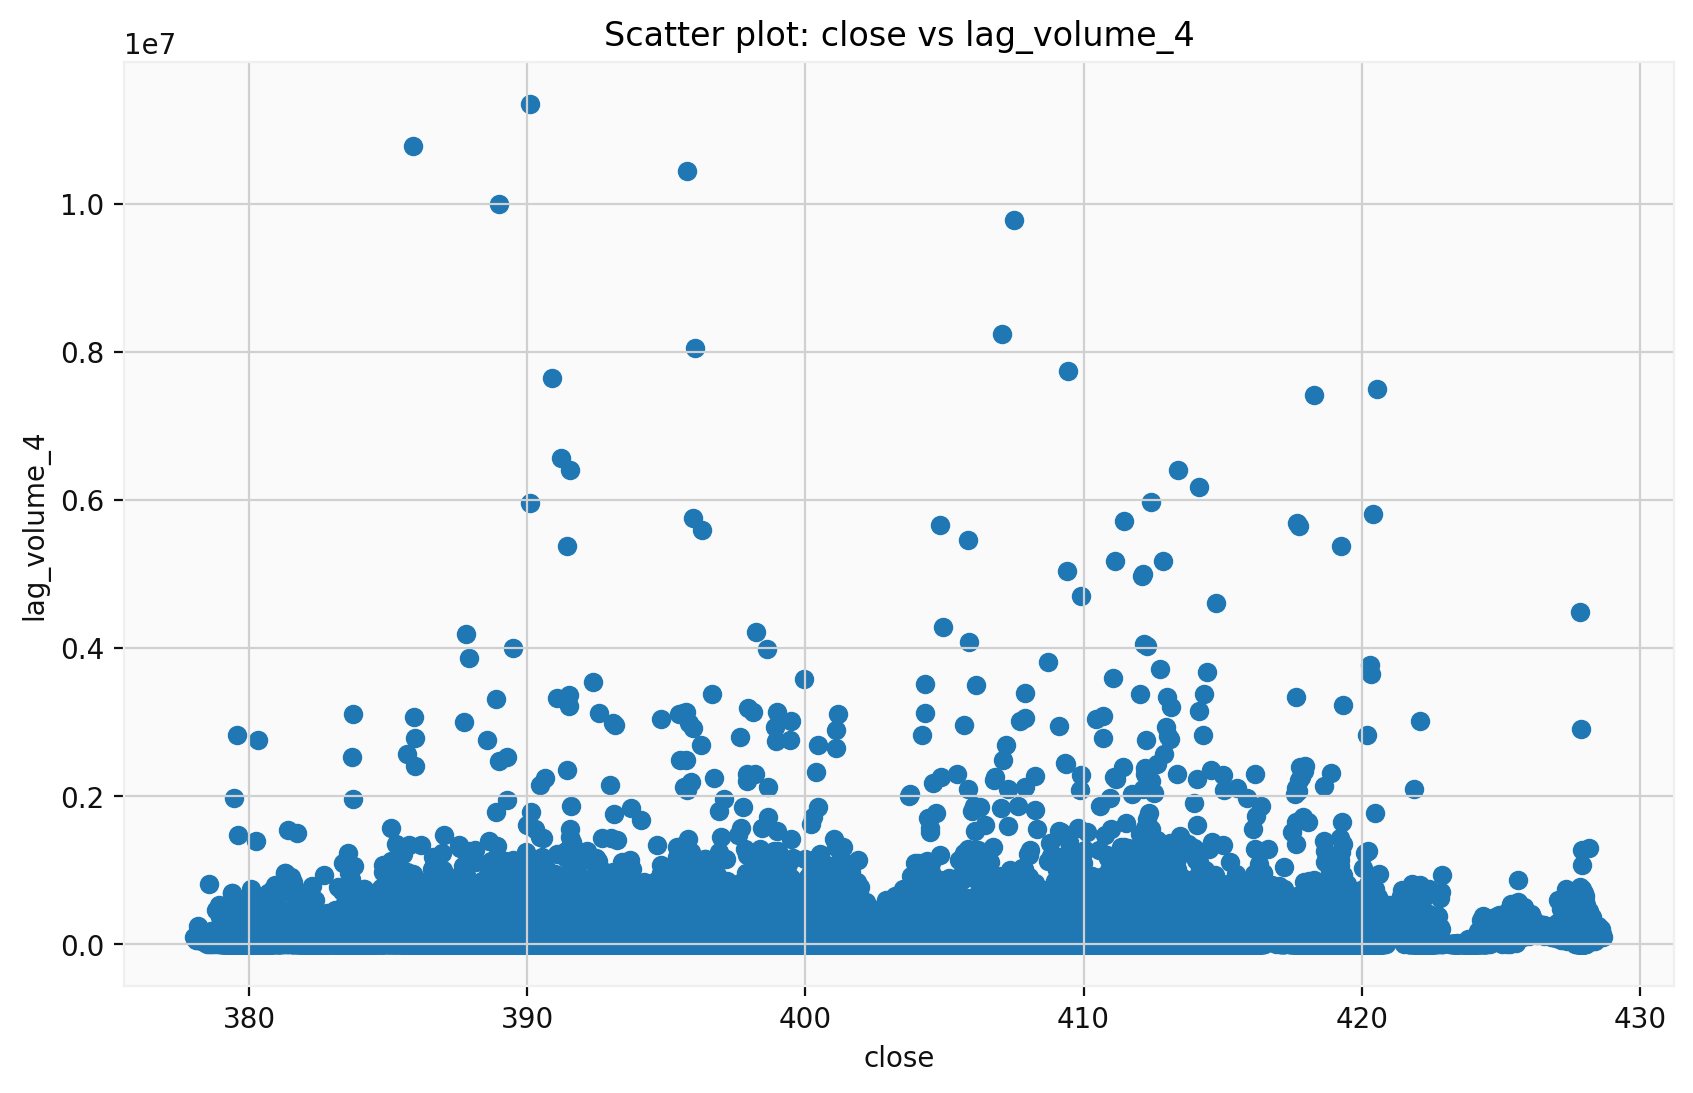

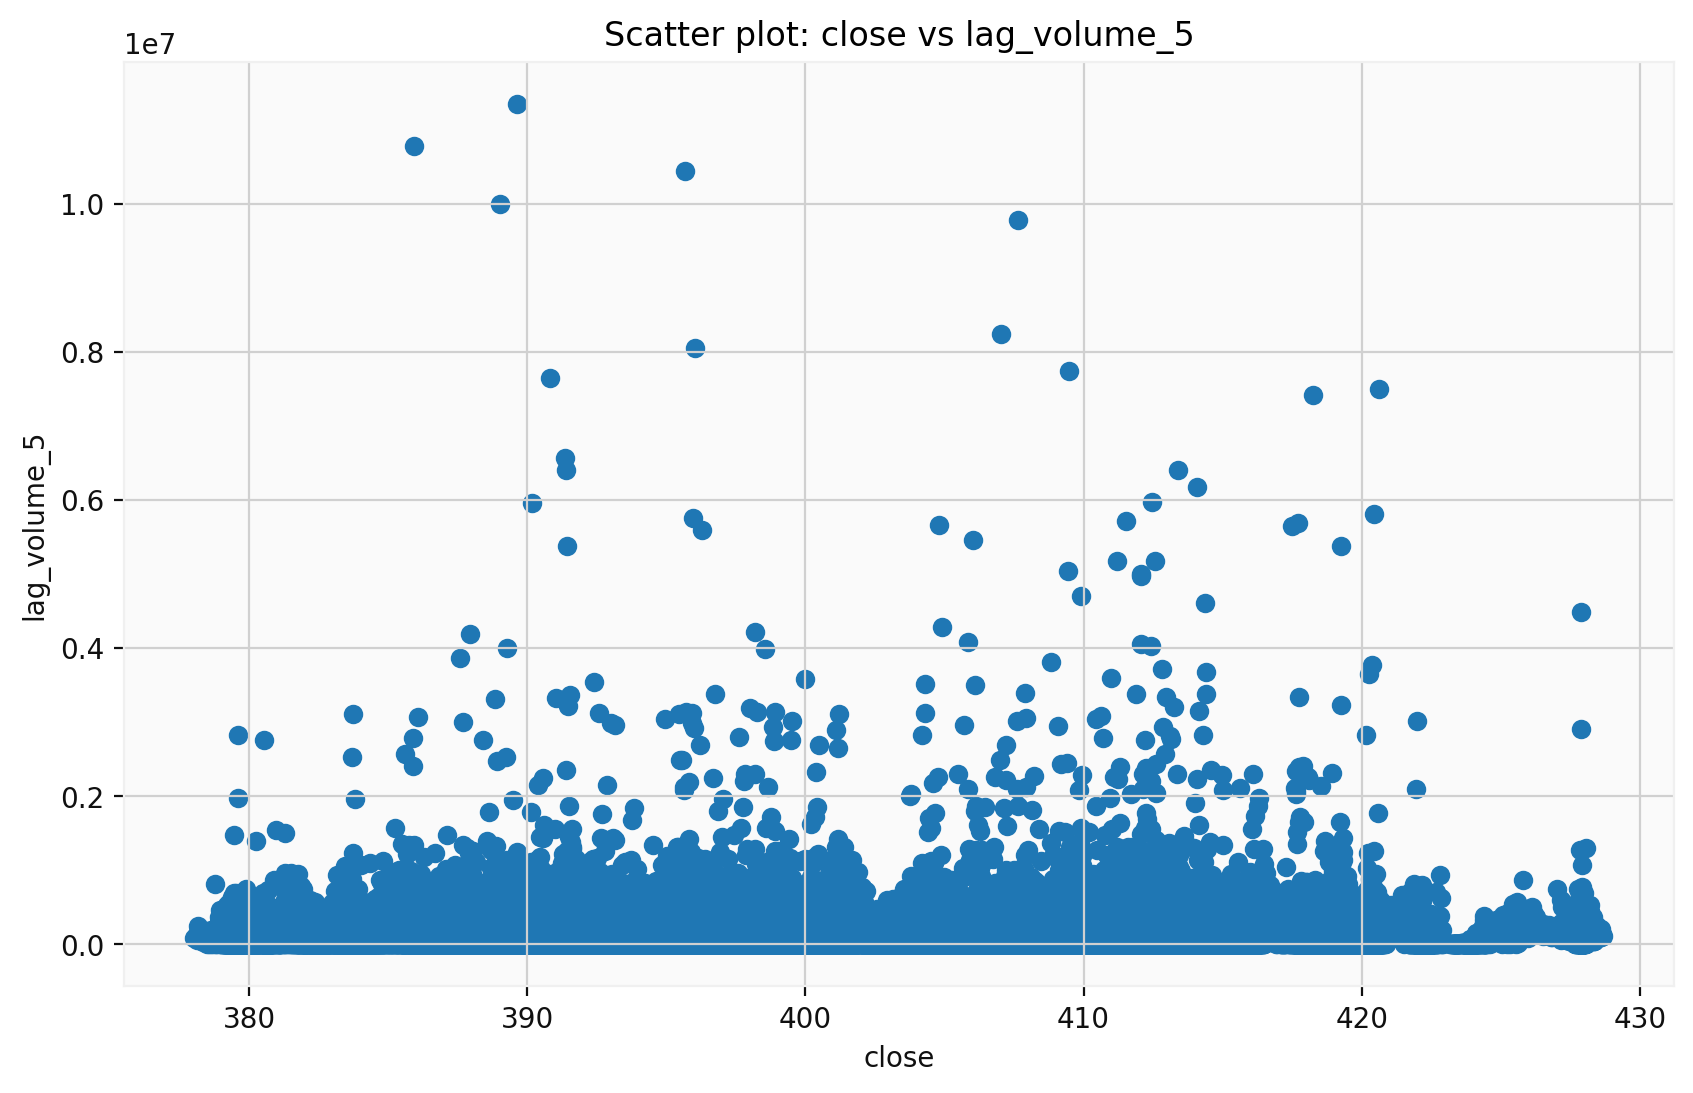

In [ ]:
target_column = 'close'  
lag_columns = ['lag_price_1', 'lag_price_2', 'lag_price_3', 'lag_price_4', 'lag_price_5', 'lag_volume_1', 'lag_volume_2', 'lag_volume_3', 'lag_volume_4', 'lag_volume_5' ]
for column in lag_columns:
    if column != target_column:
        plt.figure(figsize=(10, 6))
        plt.scatter(df[target_column], df[column])
        plt.xlabel(target_column)
        plt.ylabel(column)
        plt.title(f"Scatter plot: {'close'} vs {column}")
        plt.show()

We can see that there is a positive correlation for minute lag plots. We observe no correlation for volume lag plots.

In [ ]:
import plotly.express as px

fig = px.line(df, x='datetime', y='close', title='Close Price with Range Slider and Selectors')
fig.update_layout(hovermode="x")

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="4h", step="hour", stepmode="backward"),
            dict(count=6, label="1d", step="day", stepmode="backward"),
            dict(count=1, label="7d", step="day", stepmode="backward"),
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(step="all")
            
        ])
    )
)
fig.show()

This interactive chart is pretty useful in financial analysis for needed time frames.



### Time Series Decomposition & Statistical Tests

In order to analyze time series data, it is often helpful to decompose it into its constituent components, namely trend, seasonal, and remainder. This decomposition can be achieved by representing the series as an additive or multiplicative combination of the base level, trend, seasonal index, and residual components. The seasonal_decompose function in the statsmodels library provides a convenient way to perform this decomposition.

After decomposing the time series, it is important to assess its stationarity. This can be done by conducting statistical tests such as the KPSS (Kwiatkowski-Phillips-Schmidt-Shin) test and the Augmented Dickey-Fuller (ADF) test. These tests help determine if the series exhibits stationarity or non-stationarity, which is crucial for further analysis and modeling.

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

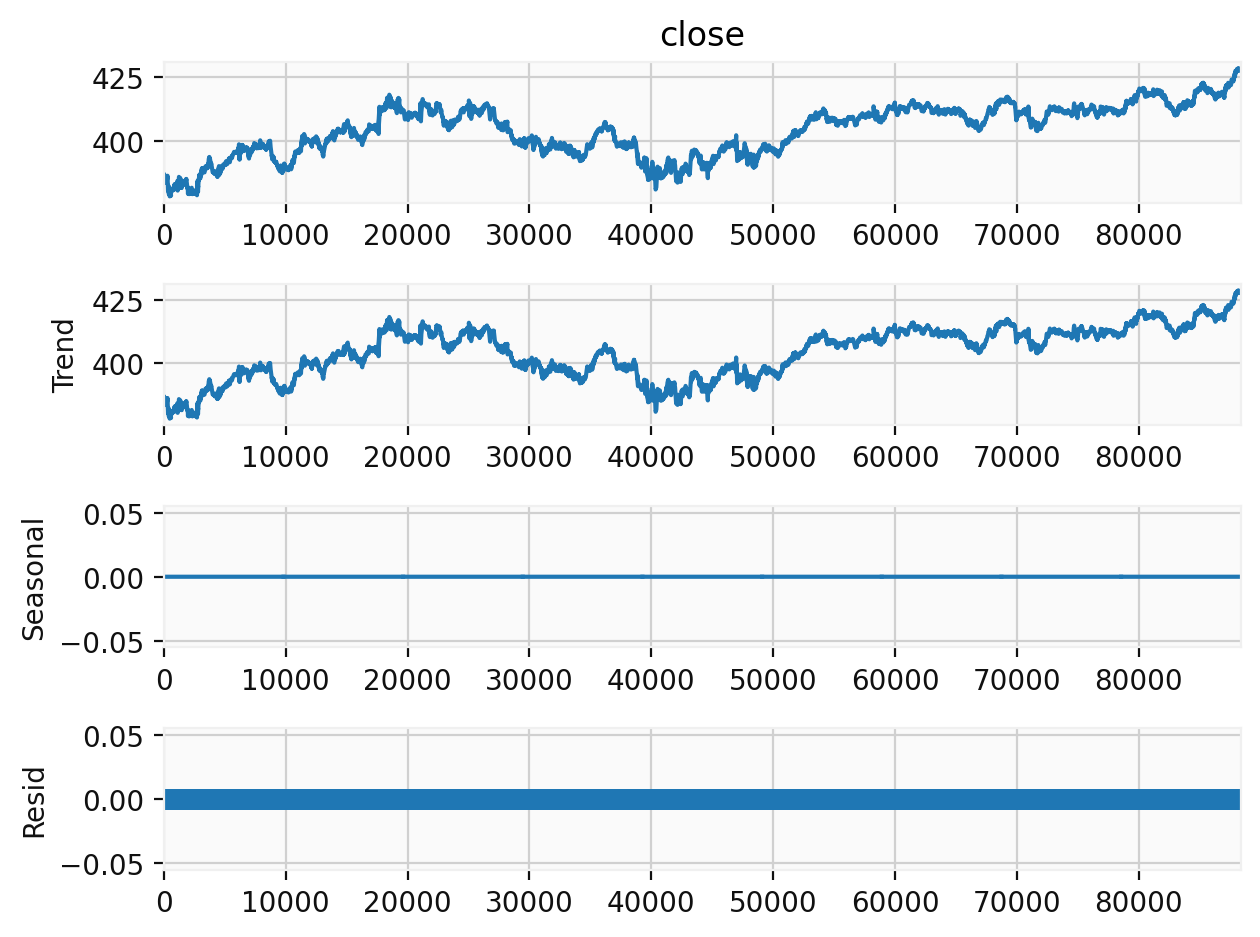

<Figure size 1500x1200 with 0 Axes>

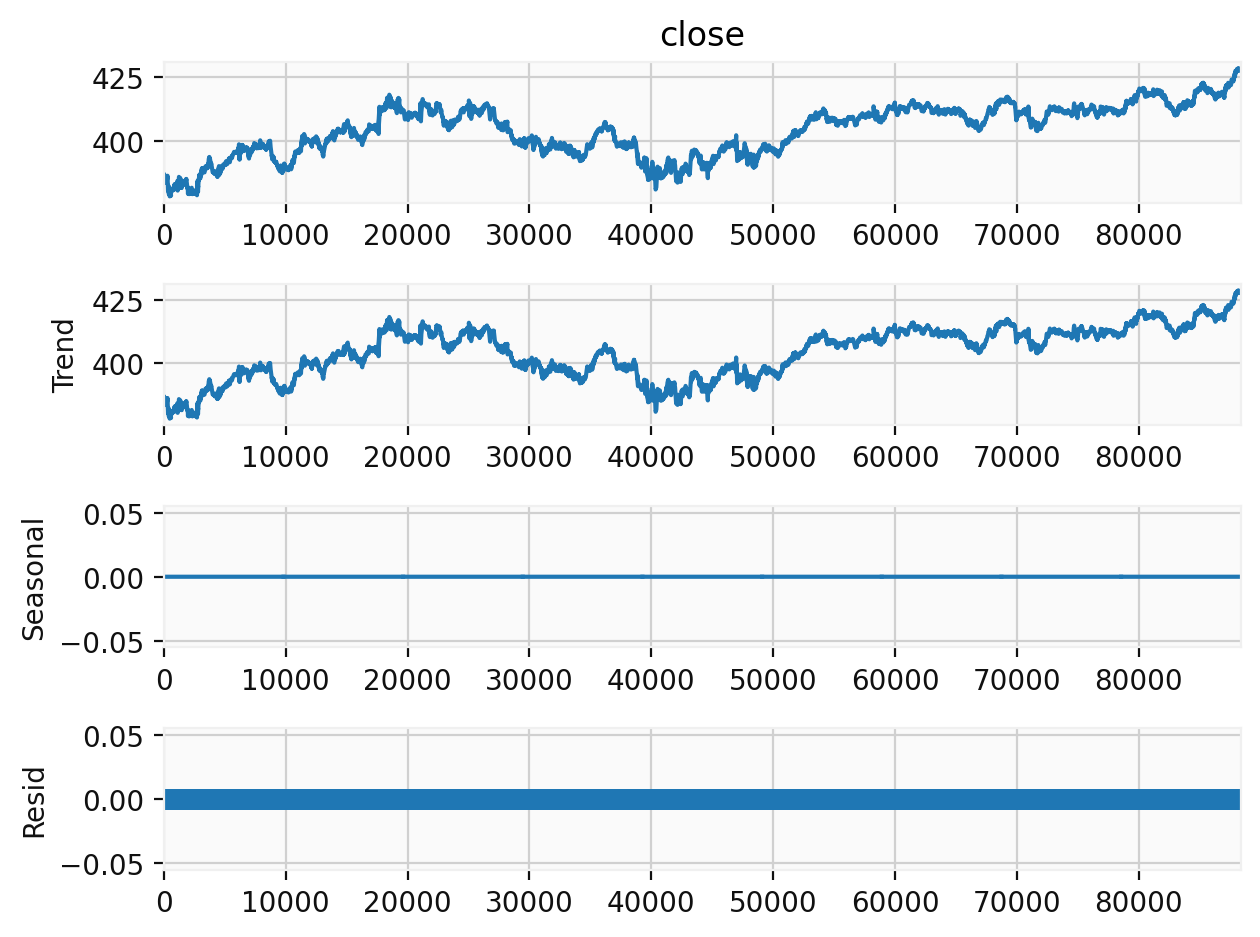

In [ ]:
plt.figure(figsize=(15,12))
series = df.close
result = seasonal_decompose(series, model='additive',period=1)
result.plot()

After decomposing the time series, we do not find any noticeable seasonal patterns. Additionally, the series exhibits non-constant mean, variance, and covariance, indicating that it is non-stationary. To confirm our observations, we will conduct statistical tests such as KPSS and ADF.

Before proceeding with the tests, let's plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) graphs.

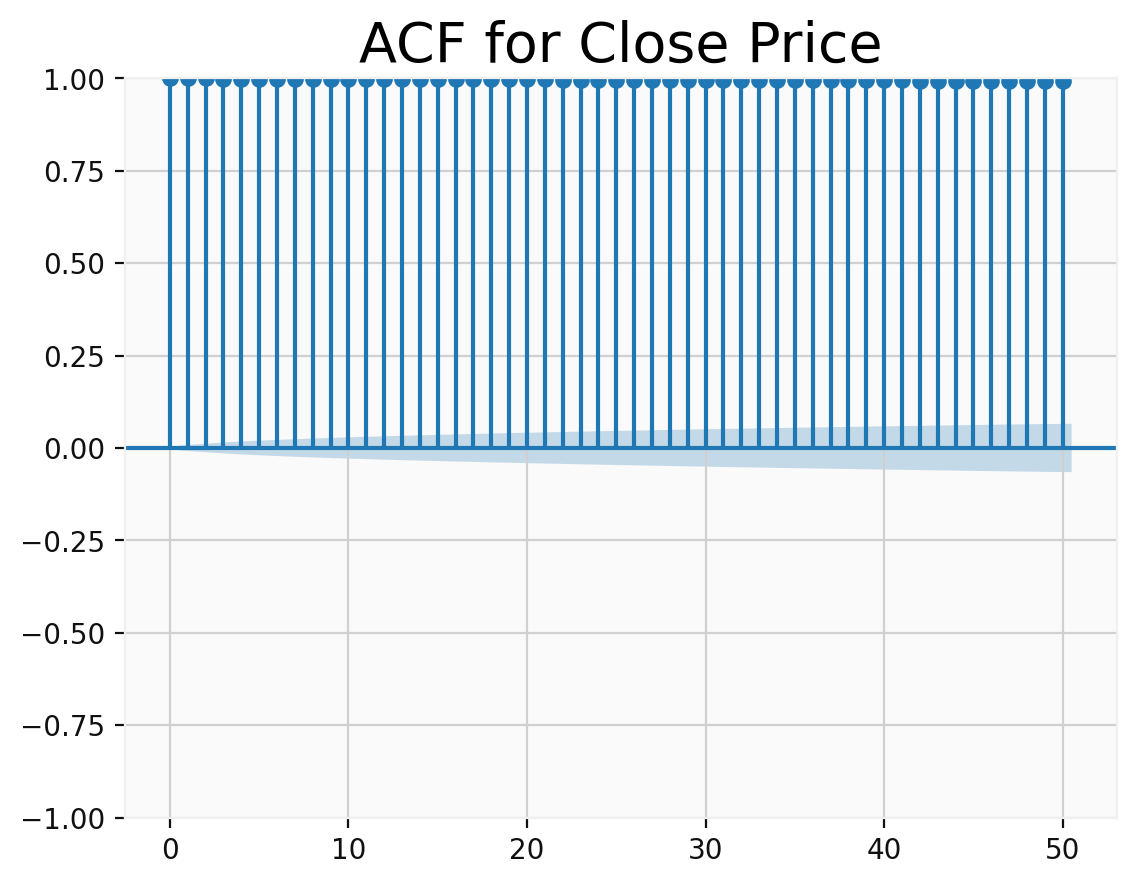

In [ ]:
acf = plot_acf(series, lags=50, alpha=0.05)
plt.title("ACF for Close Price", size=20)
plt.show()

The above graph shows that effect barely detoriate over time, so past values affect the present ones.

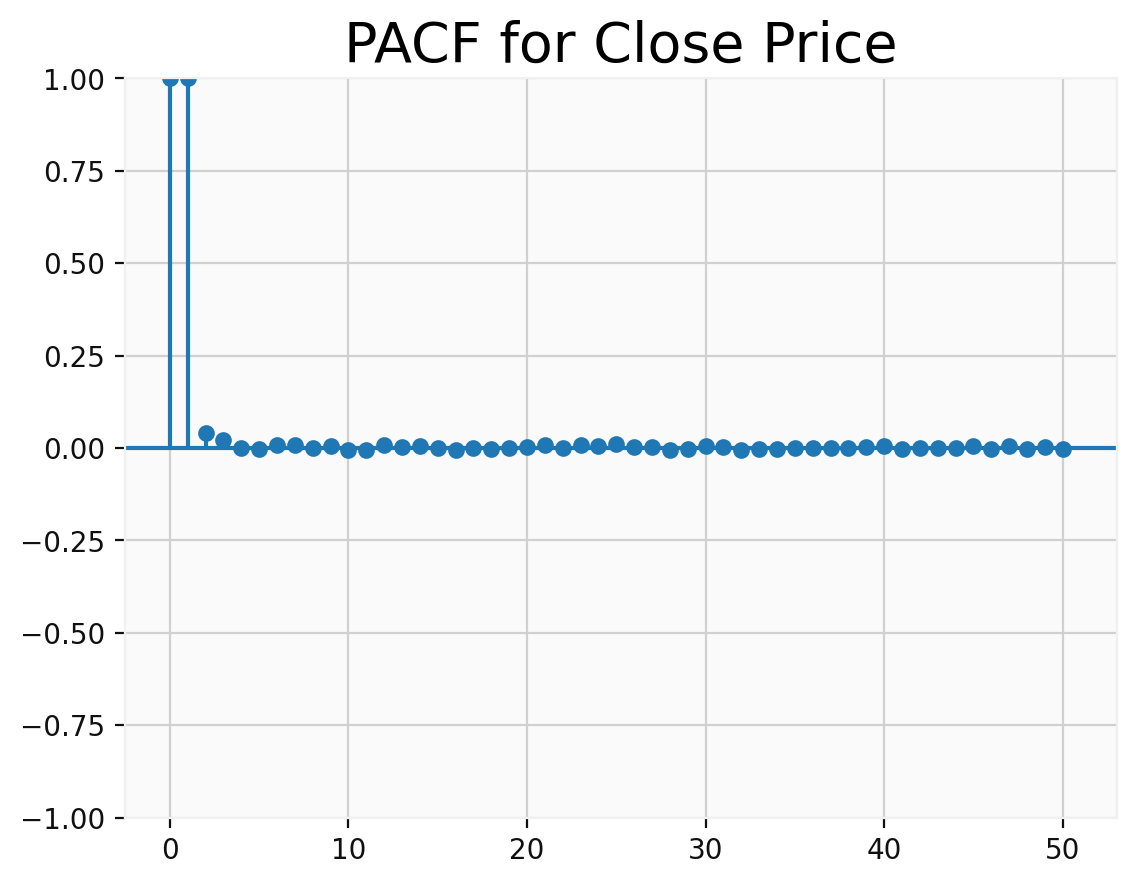

In [ ]:
plot_pacf(series, lags=50, alpha=0.05, method='ols')
plt.title("PACF for Close Price", size=20)
plt.show()

The coefficients for lag values greater than 5 are found to be statistically insignificant, indicating that their impact on the model is minimal.

### KPSS Test

In [ ]:
stats, p, lags, critical_values = kpss(series,'ct')


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [ ]:
print(f'Test Statistics : {stats}')
print(f'p-value : {p}')
print(f'Critical Values : {critical_values}')

if p < 0.05:
    print('Series is not Stationary')
else:
    print('Series is Stationary')

Test Statistics : 3.5000566193583067
p-value : 0.01
Critical Values : {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216}
Series is not Stationary


The code calculates the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test for stationarity on a time series data stored in the variable series. The test is conducted with the trend parameter set to 'ct', which means it considers a trend in the data.

After running the test, the results are stored in the variables stats, p, lags, and critical_values. 

stats: The KPSS test statistic value.
p: The p-value associated with the test statistic.
lags: The number of lags used in the test.
critical_values: A dictionary containing critical values for different significance levels (e.g., 1%, 5%, and 10%).
By analyzing the p-value, it can be determined that whether the null hypothesis of stationarity is rejected or not. If the p-value is below a chosen significance level (e.g., 0.05), the null hypothesis is rejected, indicating the presence of non-stationarity in the series.

### ADF Test


In [ ]:
def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    
    print (dfoutput)
    
    if p > 0.05:
        print('Series is not Stationary')
    else:
        print('Series is Stationary')

In [ ]:
adf_test(series)

Results of Dickey-Fuller Test:
Test Statistic                    -1.625989
p-value                            0.469591
#Lags Used                        24.000000
Number of Observations Used    88352.000000
Critical Value (1%)               -3.430424
Critical Value (5%)               -2.861573
Critical Value (10%)              -2.566787
dtype: float64
Series is Stationary


When the KPSS test indicates that the series is not stationary, while the ADF test suggests that the series is stationary, it can be a bit conflicting. In this cases, it is important to consider the characteristics of the time series and the specific requirements of the prediction model.

The choice of approach depends on the specific characteristics of the data, the goals of the prediction model, and the trade-offs to make.  In this case, XGBoost and RF will be used for modeling and forecasting without any further preprocessing  as if it is already stationary.

For a time series to be suitable for many time series forecasting models, including XGBoost, it is often desired to have a stationary time series. Stationarity allows for the assumption of a consistent data-generating process, making it easier to model and forecast the series accurately.

# Train Test Split

In [ ]:

# Define the lagged feature columns
lagged_price_features = ['lag_price_1', 'lag_price_2', 'lag_price_3', 'lag_price_4', 'lag_price_5']
lagged_volume_features = ['lag_volume_1', 'lag_volume_2', 'lag_volume_3', 'lag_volume_4', 'lag_volume_5']


In [ ]:
# Get the index corresponding to the starting point of the last month
test_start_index = 70417  

# Split the data into training and testing sets based on the index
train_data = df[:test_start_index]
test_data = df[test_start_index:]

# Split the features and target variables for training and testing
X_train = train_data[lagged_price_features + lagged_volume_features]
y_train = train_data['close']

X_test = test_data[lagged_price_features + lagged_volume_features]
y_test = test_data['close']

In [ ]:
print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (70417, 10)
Train target shape   :  (70417,)
Test features shape  :  (17960, 10)
Test target shape    :  (17960,)


Text(0.5, 1.0, 'Close Price')

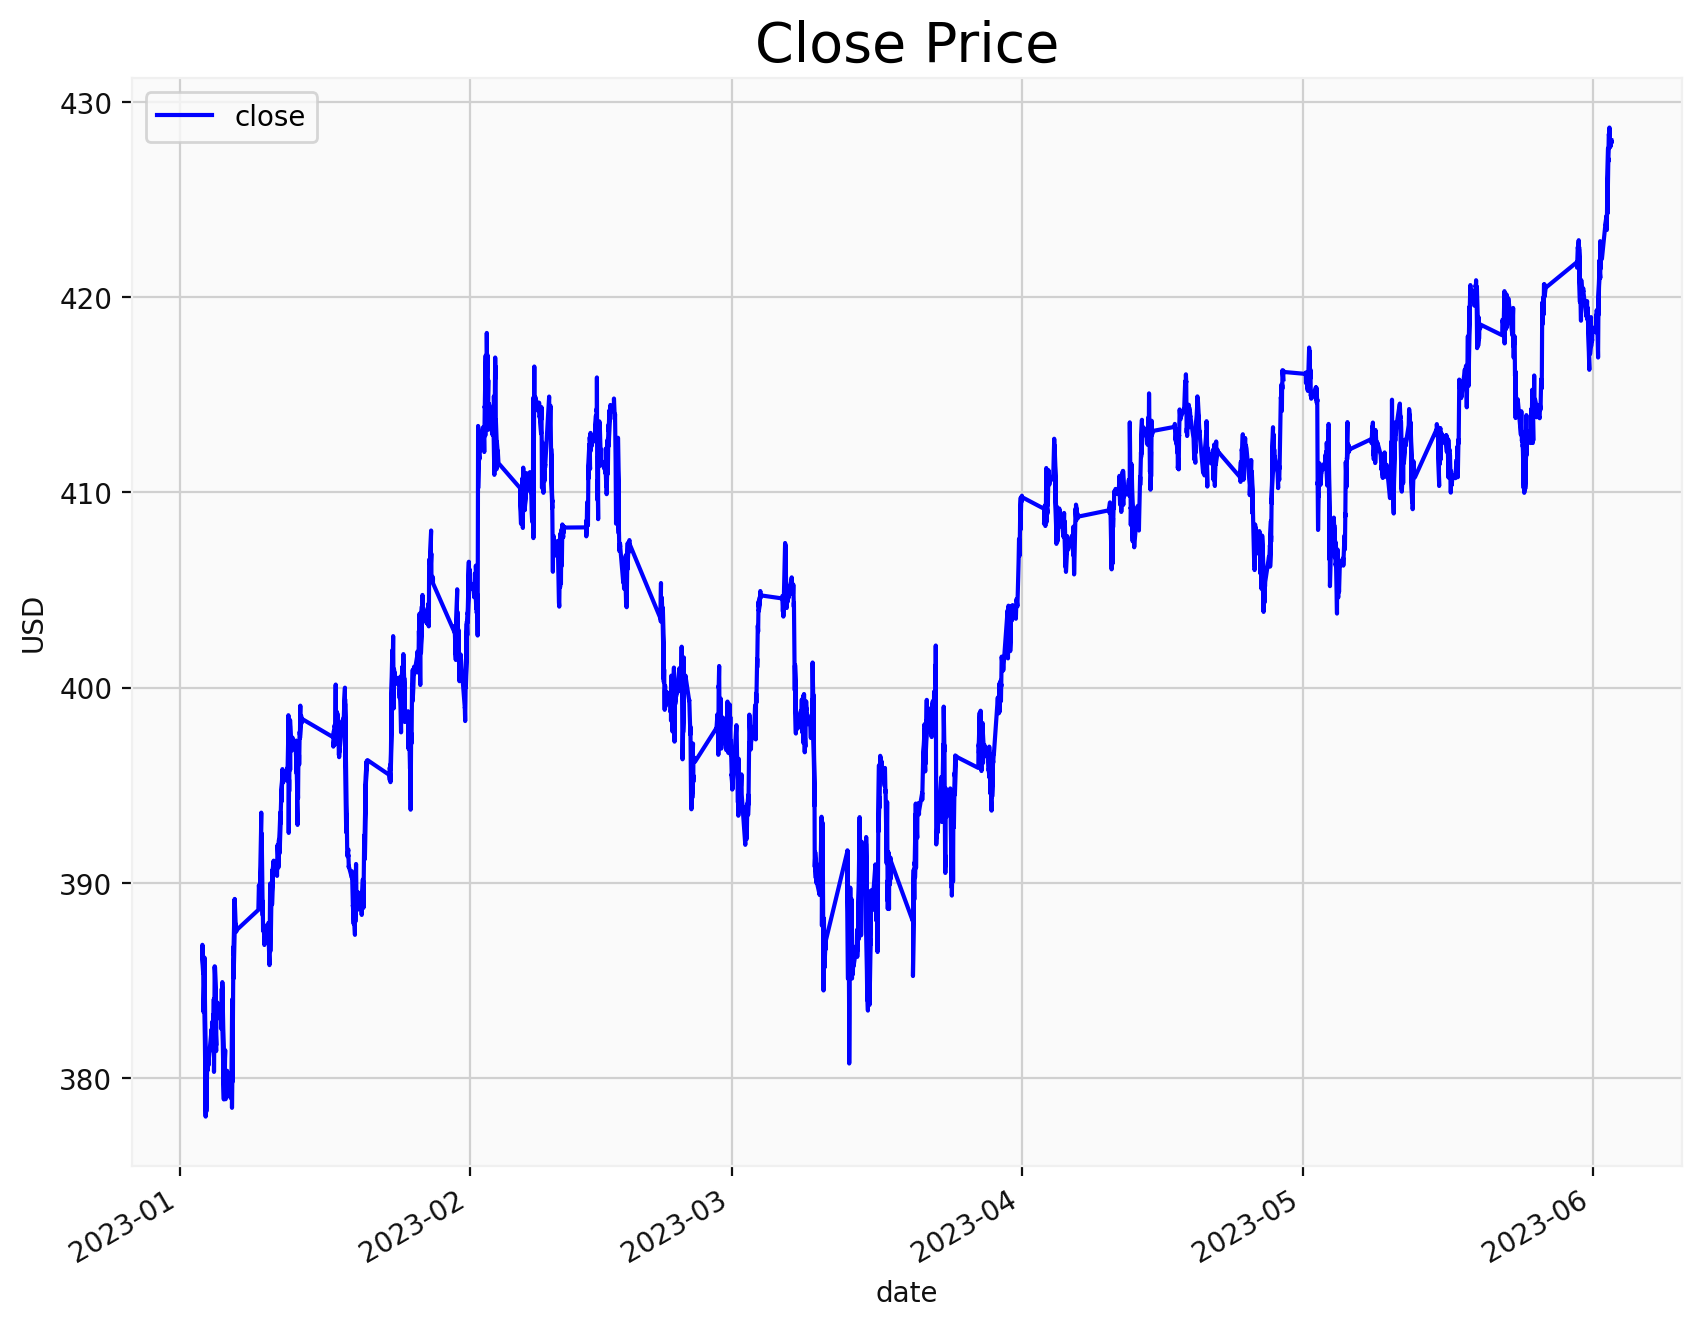

In [ ]:
# Plotted close price over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='datetime', y='close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")
plt.title("Close Price", size=20);

Text(0, 0.5, 'USD')

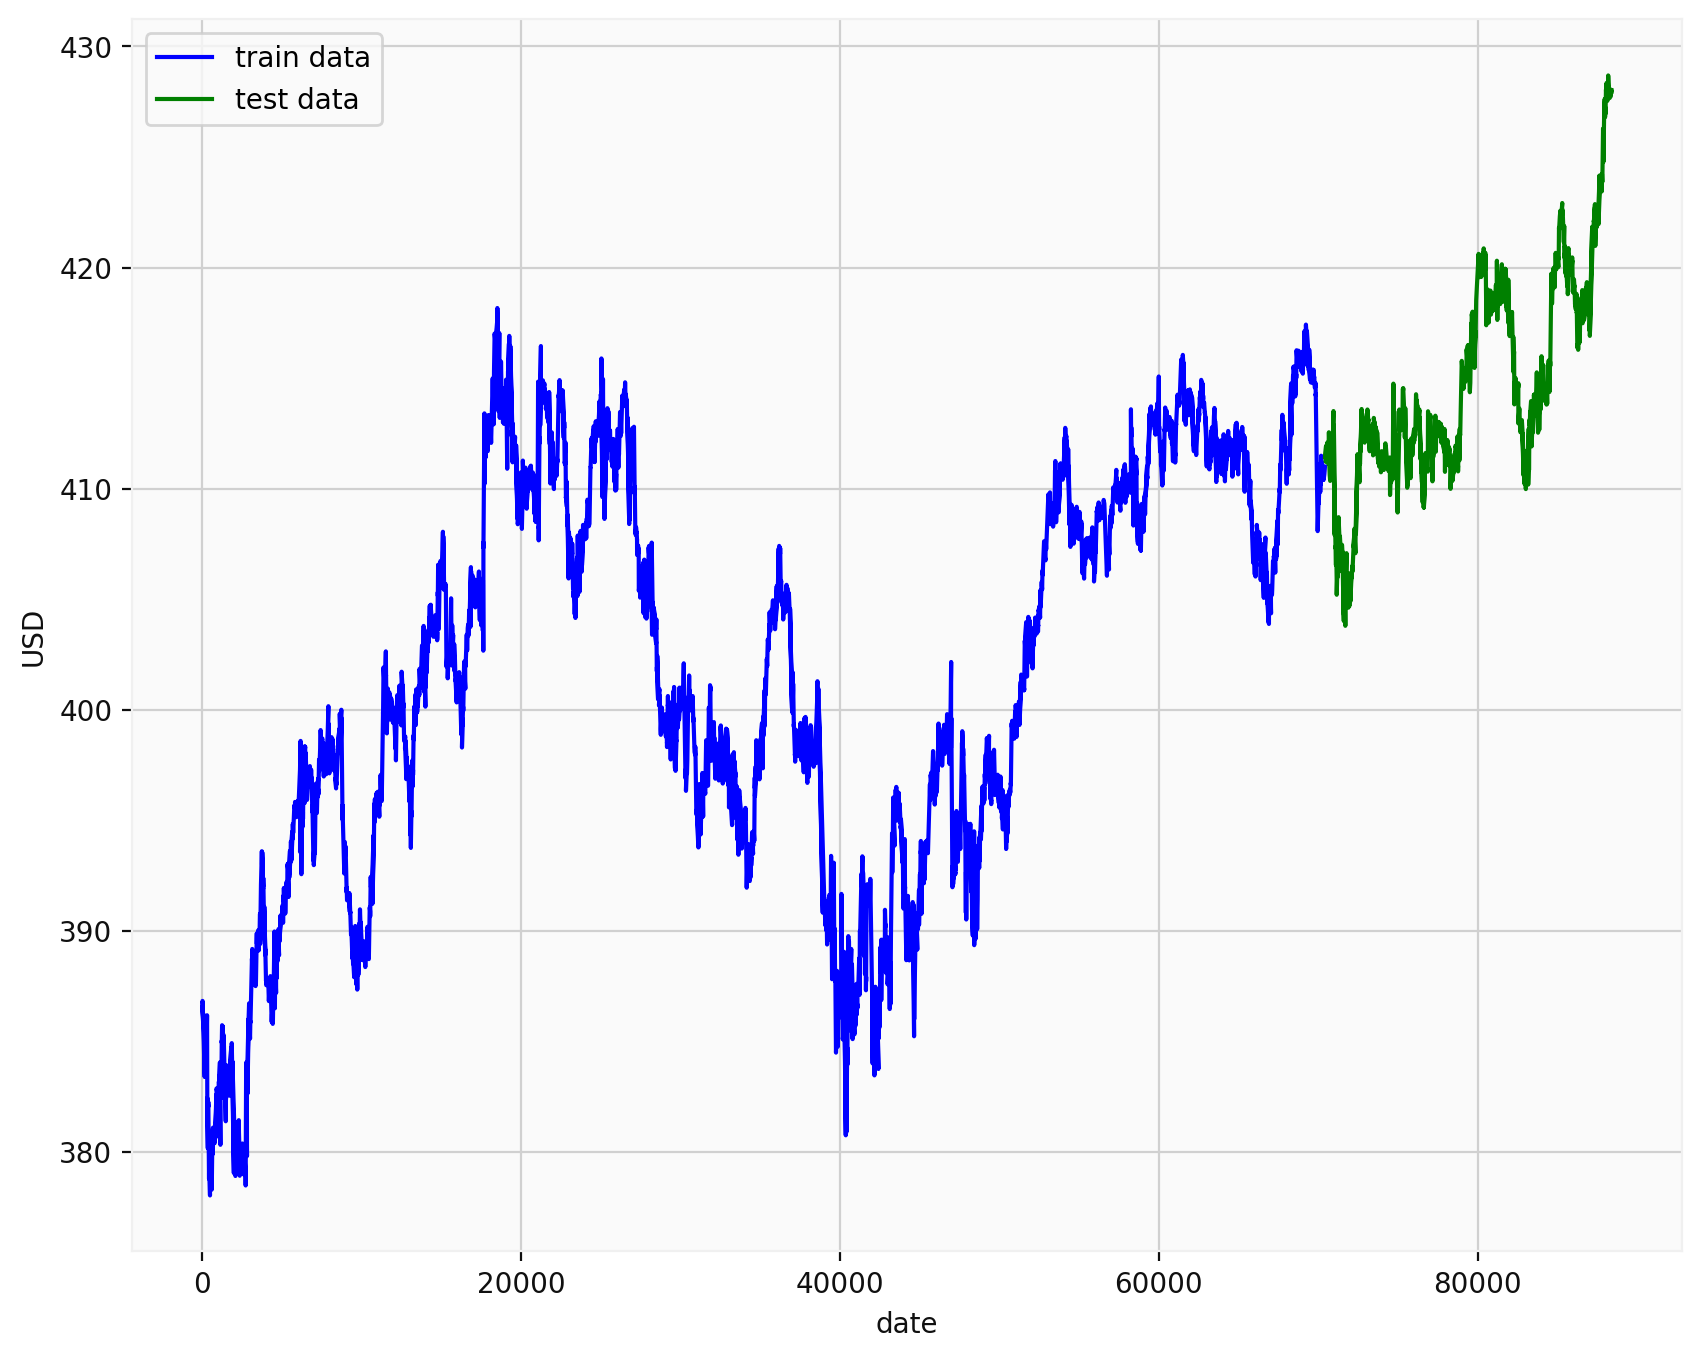

In [ ]:
# Plot train and test data
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = y_train.plot(x='datetime', y='close', style='b-', grid=True)
ax = y_test.plot(x='datetime', y='close', style='g-', grid=True, ax=ax)
ax.legend(['train data', 'test data'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

###Vanilla Random Forest Model and XGBoost Model

In [ ]:
def train_val(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    scores = {"train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    "test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [ ]:
# Random Forest Model
rf_vanilla_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_vanilla_model.fit(X_train, y_train)

# XGBoost Model
xgb_vanilla_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_vanilla_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_vanilla_model.predict(X_test)
xgb_predictions = xgb_vanilla_model.predict(X_test)

# Evaluate the models
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)

print("Vanilla Random Forest RMSE:", rf_rmse)
print("Vanilla XGBoost RMSE:", xgb_rmse)


Vanilla Random Forest RMSE: 2.1305702188299054
Vanilla XGBoost RMSE: 2.205874512155186


It seems that Random Forest model has the potential to give slightly better performance than XGBoost model.

# ANSWER 4 (Below)

# Modelling with XG Boost Regressor

In [ ]:
xgb_model = XGBRegressor(random_state=42, objective="reg:squarederror")

In [ ]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
train_val(xgb_model, X_train, y_train, X_test, y_test)

train      test
R2    0.999781  0.786132
mae   0.089798  0.950039
mse   0.018485  4.865882
rmse  0.135958  2.205875

Based on these performance results, on the training set, achieving a high R2 and low error metrics. However, it appears to have slightly worse performance on the test set, indicating a possible overfitting issue. 

In [ ]:
scores = cross_validate(xgb_model, X_train, y_train, scoring=['r2', 
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv =10)
pd.DataFrame(scores).iloc[:, 2:].mean()

test_r2                             0.996207
test_neg_mean_absolute_error       -0.133886
test_neg_mean_squared_error        -0.088820
test_neg_root_mean_squared_error   -0.220766
dtype: float64

The average R-squared value across the cross-validation folds is 0.996207. This indicates a very high level of explained variance in the target variable by the model.
The negative sign is due to the convention used in scikit-learn's scoring metrics, where higher values are considered better. 
these results suggest that the XGBoost model performs very well on the cross-validation folds, with high R-squared and low error metrics.

##Gridsearch for XGBoost

In [ ]:
param_grid = {"n_estimators":[400, 500, 700],'max_depth':[6,7,8,9], "learning_rate": [0.001, 0.01, 0.05, 0.1]}

In [ ]:

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

xgb_model = XGBRegressor(random_state=42, objective="reg:squarederror")
xgb_grid_model = HalvingGridSearchCV(
    xgb_model, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, min_resources="exhaust", factor=3
)

'''
grid_model = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          scoring='neg_root_mean_squared_error',
                          cv=10,
                          n_jobs = -1)

'''

"\ngrid_model = GridSearchCV(estimator=model,\n                          param_grid=param_grid,\n                          scoring='neg_root_mean_squared_error',\n                          cv=10,\n                          n_jobs = -1)\n\n"

In [ ]:
%%time
xgb_grid_model.fit(X_train, y_train)

CPU times: user 2min 23s, sys: 2 s, total: 2min 25s
Wall time: 45min 19s


HalvingGridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=42, ...),
                    n_jobs=-1,
                    param_grid={'learning_rate': [0.001, 0.01, 0.05, 0.1],
                                'max_depth': [6, 7, 8, 9],
                                'n_estimators': [400, 500, 700]},
                    scoring='neg_root_mean_squared_error')

In [ ]:
xgb_grid_model.best_params_

{'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 500}

In [ ]:
xgb_grid_model.best_score_

-0.21802267136226416

In [ ]:
train_val(xgb_grid_model, X_train, y_train, X_test, y_test)

train      test
R2    0.999795  0.772347
mae   0.088407  0.999912
mse   0.017377  5.179498
rmse  0.131820  2.275851

In [ ]:
# Access the best estimator
xgb_best_model = xgb_grid_model.best_estimator_

In [ ]:
# Get predictions on the test set using the best estimator
xgb_pred = xgb_best_model.predict(X_test)

In [ ]:
df['xgb_predictions'] = None

In [ ]:
df.iloc[-17960:, df.columns.get_loc('xgb_predictions')] = xgb_pred

In [ ]:
df['xgb_predictions'] 

0              None
1              None
2              None
3              None
4              None
            ...    
88372      417.5448
88373    417.541229
88374    417.553589
88375     417.54248
88376    417.532532
Name: xgb_predictions, Length: 88377, dtype: object

In [ ]:
xgb_predictions= df['xgb_predictions']

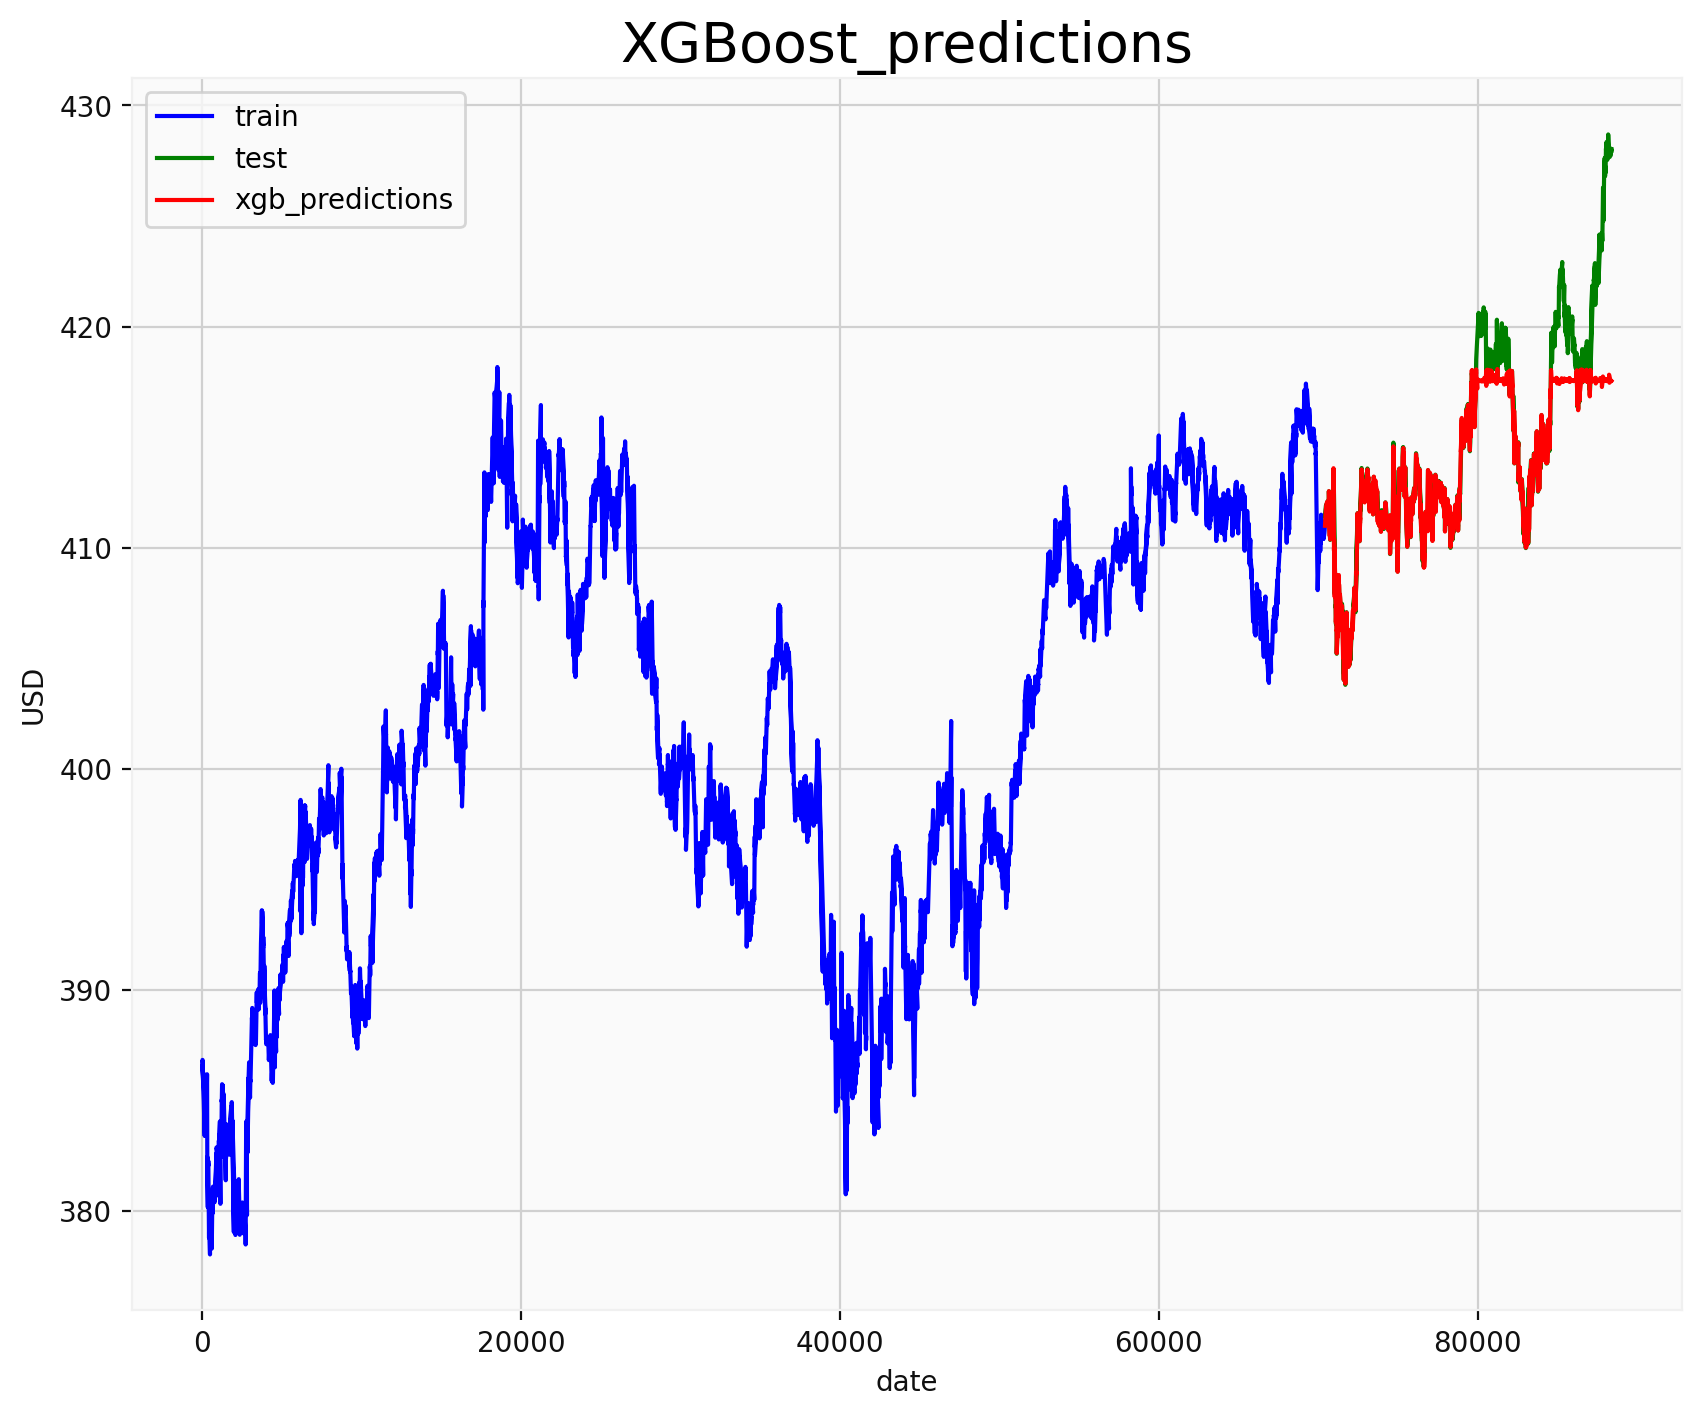

In [ ]:
ax = y_train.plot(x='datetime', y='close', style='b-', grid=True)
ax = y_test.plot(x='datetime', y='close', style='g-', grid=True, ax=ax)
ax = xgb_predictions.plot(x='datetime', y='pred', style='r-', grid=True, ax=ax)
ax.legend(['train', 'test', 'xgb_predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
plt.title("XGBoost_predictions", size=20);

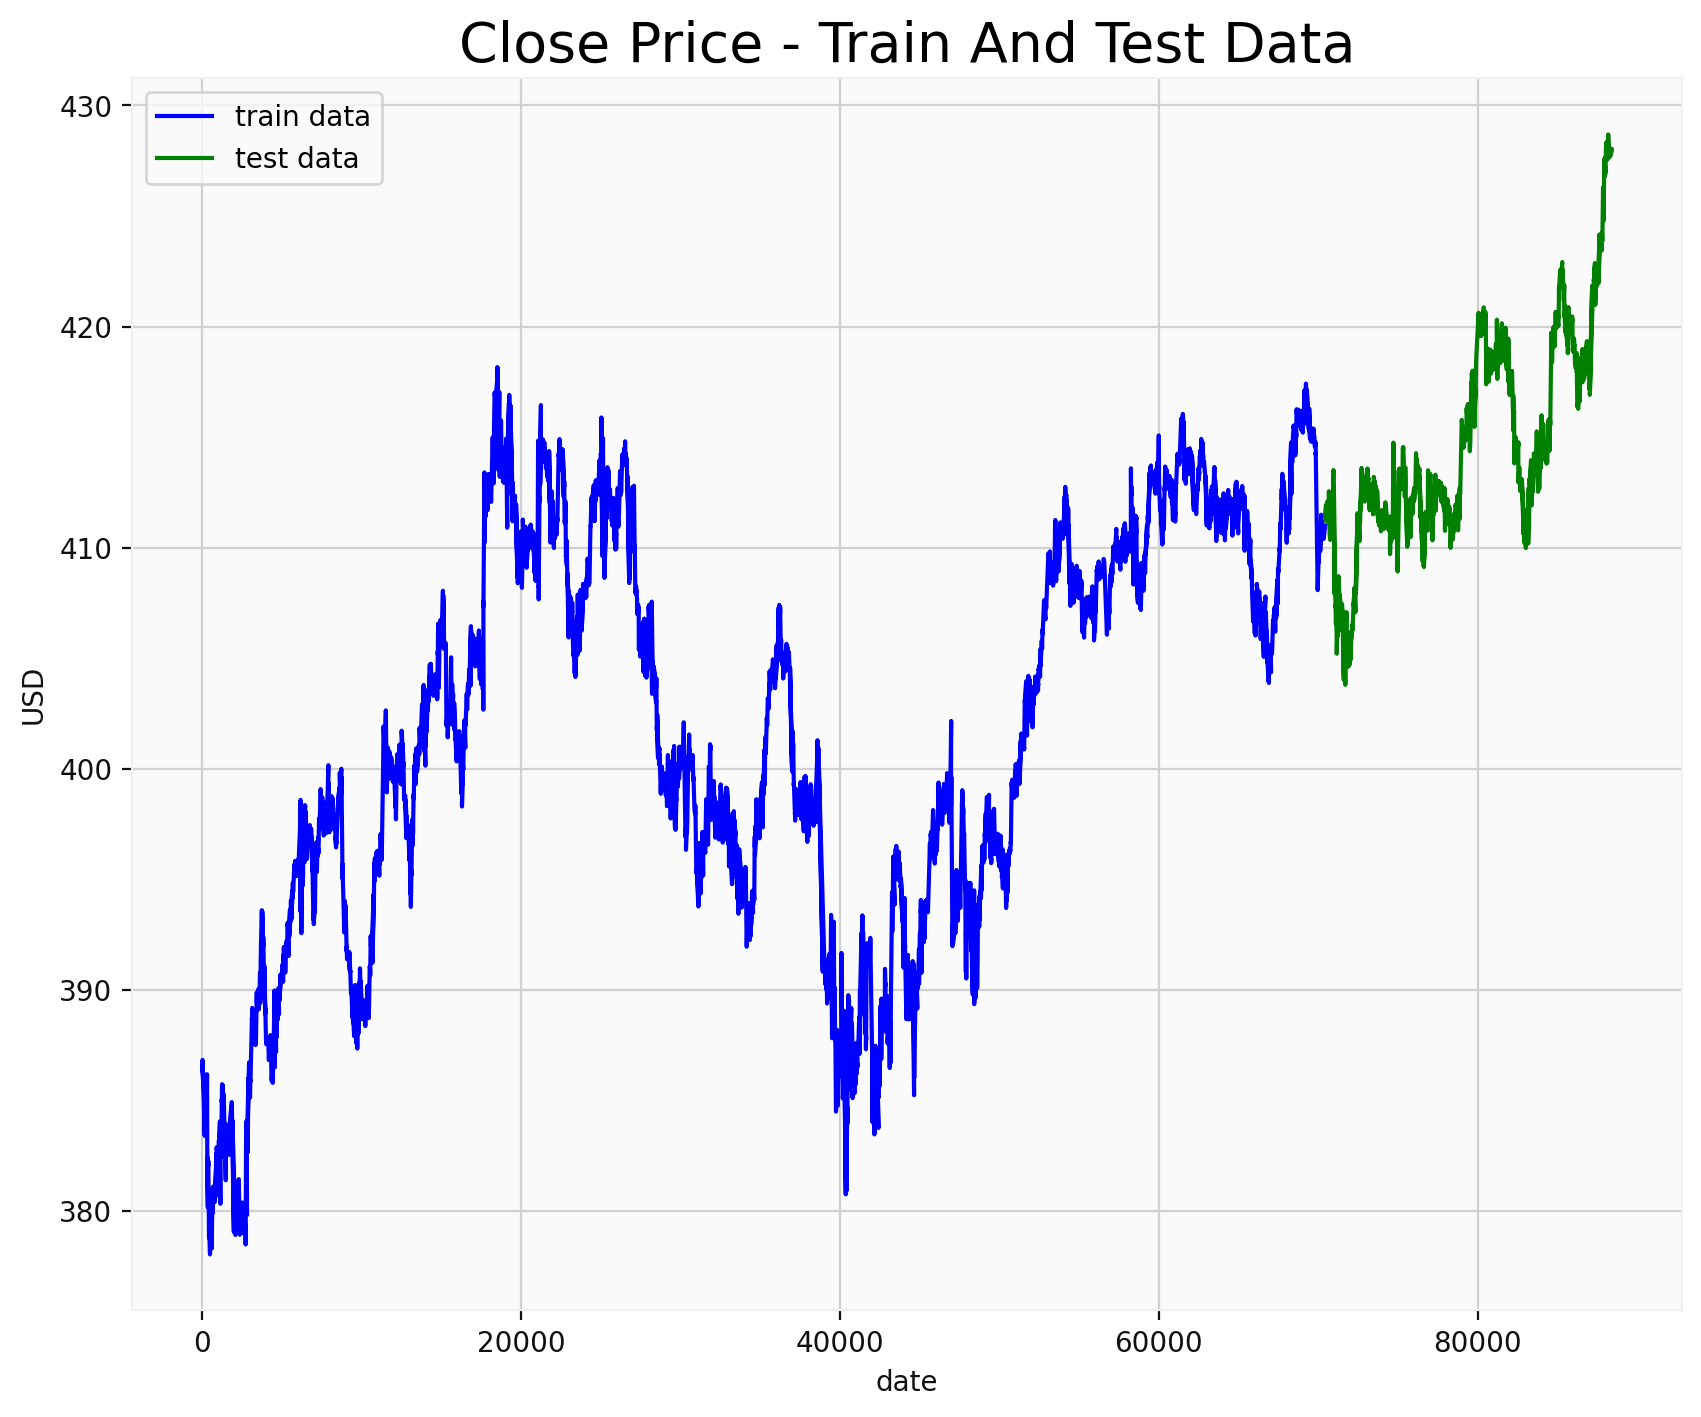

In [ ]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = y_train.plot(x='datetime', y='close', style='b-', grid=True)
ax = y_test.plot(x='datetime', y='close', style='g-', grid=True, ax=ax)
ax.legend(['train data', 'test data'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
plt.title("Close Price - Train And Test Data", size=20);

##Feature importance

In [ ]:
xgb_model = XGBRegressor(random_state=42, objective="reg:squarederror",learning_rate=0.05, max_depth=8, n_estimators= 500)
xgb_model.fit(X_train, y_train)   

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
xgb_model.feature_importances_

array([9.9531996e-01, 2.7828482e-03, 1.2744943e-03, 2.2107935e-04,
       2.8708638e-04, 2.3069933e-05, 2.4515244e-05, 2.0443749e-05,
       2.2092052e-05, 2.4361239e-05], dtype=float32)

In [ ]:
imp_feats = pd.DataFrame(index=X_train.columns,data=xgb_model.feature_importances_,columns=['xgb_Importance'])
xgb_imp_feats = imp_feats.sort_values('xgb_Importance', ascending=False)
xgb_imp_feats

xgb_Importance
lag_price_1         0.995320
lag_price_2         0.002783
lag_price_3         0.001274
lag_price_5         0.000287
lag_price_4         0.000221
lag_volume_2        0.000025
lag_volume_5        0.000024
lag_volume_1        0.000023
lag_volume_4        0.000022
lag_volume_3        0.000020

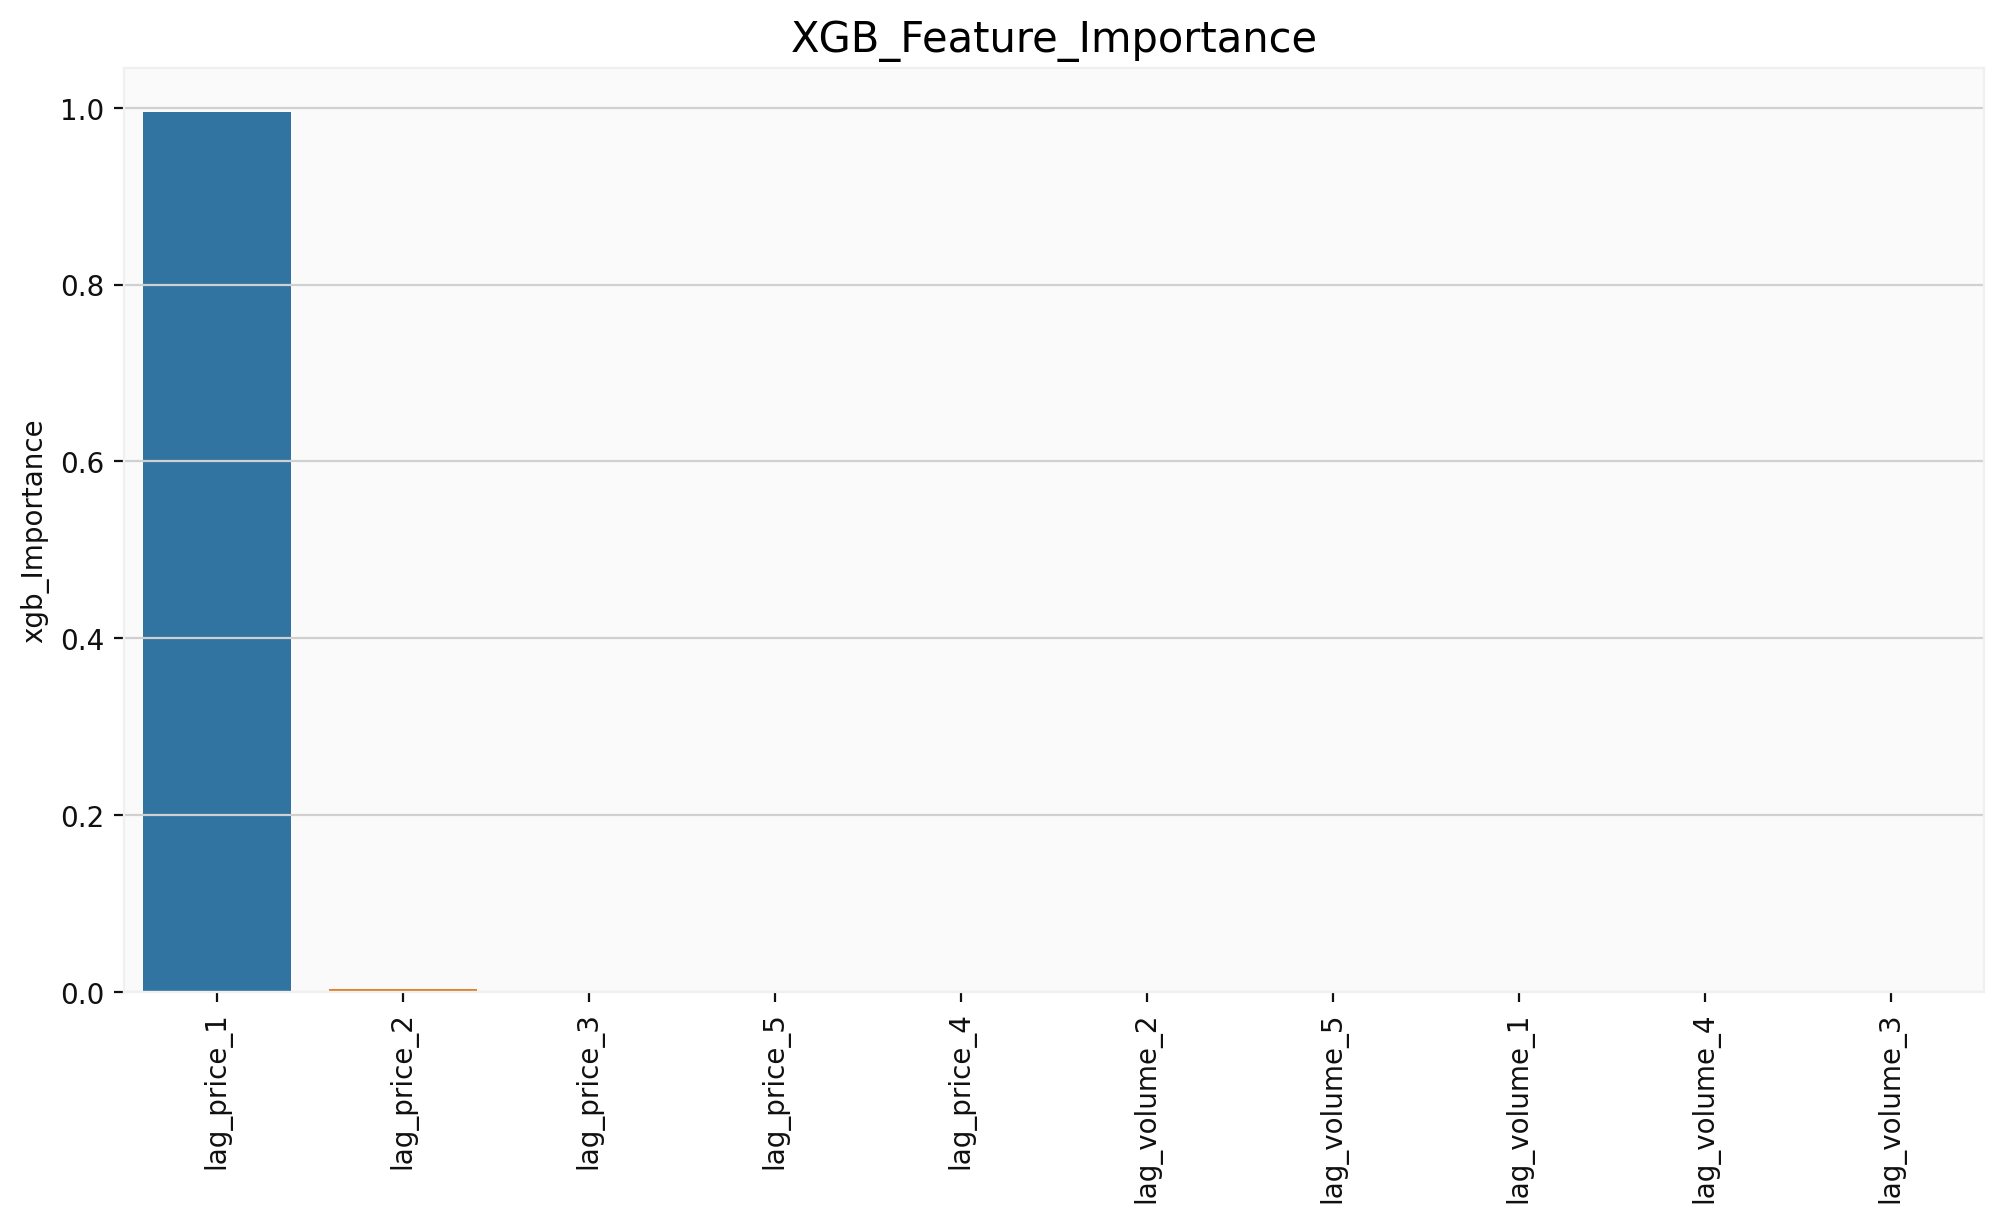

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(data=xgb_imp_feats, x=xgb_imp_feats.index, y='xgb_Importance')

plt.xticks(rotation=90)
plt.title("XGB_Feature_Importance", size=15);

# Metrics Selection For Reporting The Performance  (ANSWER 5)

To evaluate the effectiveness of methods, R-squared (R2), root mean square error (RMSE), mean square error (MSE) and mean absolute error (MAE) metrics are used. For all metrics except R2, the lower the value, the better the prediction. Here is a berief explanation:

R-squared (R2): R-squared is a statistical measure that represents the proportion of the variance in the dependent variable (target variable) that can be explained by the independent variables (features) in the model. It ranges from 0 to 1, where 0 indicates that the model does not explain any of the variance, and 1 indicates a perfect fit. When there is large difference between R2 of train and test, there would be overfitting or underfitting issue. In our case there is overfitting.


For stock price prediction with an XGBoost model, the most commonly used evaluation metric is the root mean squared error (RMSE). RMSE is preferred in this context because it gives higher weight to larger prediction errors, which is important when dealing with financial data and trying to minimize the impact of large errors.
When there is large difference between RMSE and MAE model is making large errors.



# Modeling with Random Forest

In [ ]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train,y_train)
train_val(rf_model, X_train, y_train, X_test, y_test)

train      test
R2    0.999957  0.800484
mae   0.037140  0.896346
mse   0.003626  4.539329
rmse  0.060214  2.130570

In [ ]:

model = RandomForestRegressor(random_state=42)
scores = cross_validate(model, X_train, y_train, scoring=['r2', 
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv =10, return_train_score=True)
df_scores = pd.DataFrame(scores)
df_scores.mean()[2:]

test_r2                              0.996596
train_r2                             0.999957
test_neg_mean_absolute_error        -0.128278
train_neg_mean_absolute_error       -0.037127
test_neg_mean_squared_error         -0.074697
train_neg_mean_squared_error        -0.003606
test_neg_root_mean_squared_error    -0.213203
train_neg_root_mean_squared_error   -0.060030
dtype: float64

##Gridsearch for RF

In [ ]:
model = RandomForestRegressor(random_state=42)

In [ ]:
param_grid = {"n_estimators":[300,400,500],
              "max_depth": [8,9,10],
              "min_samples_leaf": [1, 2, 3],
              "min_samples_split": [2, 3, 5],
              "max_features":['auto']}

In [ ]:
grid_model = HalvingGridSearchCV(
    model, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, min_resources="exhaust", factor=3
)


In [ ]:
grid_model.fit(X_train,y_train)

HalvingGridSearchCV(estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                    param_grid={'max_depth': [8, 9, 10],
                                'max_features': ['auto'],
                                'min_samples_leaf': [1, 2, 3],
                                'min_samples_split': [2, 3, 5],
                                'n_estimators': [300, 400, 500]},
                    scoring='neg_root_mean_squared_error')

In [ ]:
grid_model.best_estimator_

RandomForestRegressor(max_depth=9, max_features='auto', n_estimators=500,
                      random_state=42)

In [ ]:
grid_model.best_params_

{'max_depth': 9,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [ ]:
grid_score =pd.DataFrame(grid_model.cv_results_)
grid_score

iter  n_resources  mean_fit_time  std_fit_time  mean_score_time  std_score_time param_max_depth param_max_features param_min_samples_leaf param_min_samples_split param_n_estimators                                             params  split0_test_score  split1_test_score  split2_test_score  split3_test_score  split4_test_score  mean_test_score  std_test_score  rank_test_score  split0_train_score  split1_train_score  split2_train_score  split3_train_score  split4_train_score  mean_train_score  std_train_score
0       0          869       3.461299      0.716005         0.078390        0.023283               8               auto                      1                       2                300  {'max_depth': 8, 'max_features': 'auto', 'min_...          -1.325780          -0.213353          -0.211516          -0.171671          -0.183618        -0.421188        0.452580               43           -0.090854           -0.081014           -0.087866           -0.078530           -0.076182         -0.082889         0.005581
1       0          869       3.332865      0.761758         0.070835        0.024720               8               auto                      1                       2                400  {'max_depth': 8, 'max_features': 'auto', 'min_...          -1.344453          -0.213604          -0.211732          -0.171842          -0.181081        -0.424542        0.460250               50           -0.090987           -0.080673           -0.087462           -0.078446           -0.075881         -0.082690         0.005658
2       0          869       3.453147      0.150192         0.075143        0.007513               8               auto                      1                       2                500  {'max_depth': 8, 'max_features': 'auto', 'min_...          -1.335654          -0.214401          -0.211100          -0.171972          -0.180658        -0.422757        0.456749               45           -0.090389           -0.081002           -0.087246           -0.078314           -0.075682         -0.082527         0.005496
3       0          869       2.690178      0.699170         0.053064        0.018637               8               auto                      1                       3                300  {'max_depth': 8, 'max_features': 'auto', 'min_...          -1.351157          -0.214123          -0.213753          -0.172824          -0.184309        -0.427233        0.462247               56           -0.099561           -0.081368           -0.089260           -0.080022           -0.077426         -0.085527         0.008051
4       0          869       2.729715      0.120668         0.070215        0.025075               8               auto                      1                       3                400  {'max_depth': 8, 'max_features': 'auto', 'min_...          -1.355267          -0.213462          -0.213820          -0.172860          -0.181040        -0.427290        0.464286               57           -0.099387           -0.081019           -0.089238           -0.079912           -0.077313         -0.085374         0.008063
5       0          869       3.981159      0.555985         0.081483        0.013259               8               auto                      1                       3                500  {'max_depth': 8, 'max_features': 'auto', 'min_...          -1.339094          -0.214411          -0.213408          -0.172730          -0.181458        -0.424220        0.457742               49           -0.098564           -0.081349           -0.088545           -0.079932           -0.076959         -0.085070         0.007749
6       0          869       2.333514      0.653965         0.046777        0.011038               8               auto                      1                       5                300  {'max_depth': 8, 'max_features': 'auto', 'min_...          -1.362439          -0.218183          -0.216345          -0.171844          -0.192401        -0.432242        0.465410               62     

In [ ]:
grid_model.best_index_

120

In [ ]:
grid_model.best_score_

-0.22862664064041374

In [ ]:
train_val(grid_model, X_train, y_train, X_test, y_test)

train      test
R2    0.999770  0.802025
mae   0.089428  0.886862
mse   0.019477  4.504281
rmse  0.139558  2.122329

##Cross Validate For RF

In [ ]:
rf_cv_model = RandomForestRegressor( max_depth = 9,
             max_features= 'auto',
             min_samples_leaf = 1,
             min_samples_split= 2,
             n_estimators= 500 , random_state=42)
scores = cross_validate(rf_cv_model, X_train, y_train, scoring=['r2', 
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv = 10, return_train_score=True)
df_scores = pd.DataFrame(scores)
df_scores.mean()[2:]

test_r2                              0.996722
train_r2                             0.999769
test_neg_mean_absolute_error        -0.122718
train_neg_mean_absolute_error       -0.089083
test_neg_mean_squared_error         -0.073622
train_neg_mean_squared_error        -0.019217
test_neg_root_mean_squared_error    -0.207844
train_neg_root_mean_squared_error   -0.138584
dtype: float64

## Feature Importance

In [ ]:
rf_cv_model.fit(X_train,y_train)

RandomForestRegressor(max_depth=9, max_features='auto', n_estimators=500,
                      random_state=42)

In [ ]:
rf_cv_model.feature_importances_

array([9.99418244e-01, 5.52452370e-04, 7.41019204e-06, 5.85798973e-06,
       6.05205517e-06, 1.95639752e-06, 2.40801787e-06, 1.89631901e-06,
       1.61791497e-06, 2.10480909e-06])

In [ ]:
df_f_i = pd.DataFrame(index=X_train.columns, data = rf_cv_model.feature_importances_, 
                      columns = ["Feature Importance"])
df_f_i

Feature Importance
lag_price_1             0.999418
lag_price_2             0.000552
lag_price_3             0.000007
lag_price_4             0.000006
lag_price_5             0.000006
lag_volume_1            0.000002
lag_volume_2            0.000002
lag_volume_3            0.000002
lag_volume_4            0.000002
lag_volume_5            0.000002

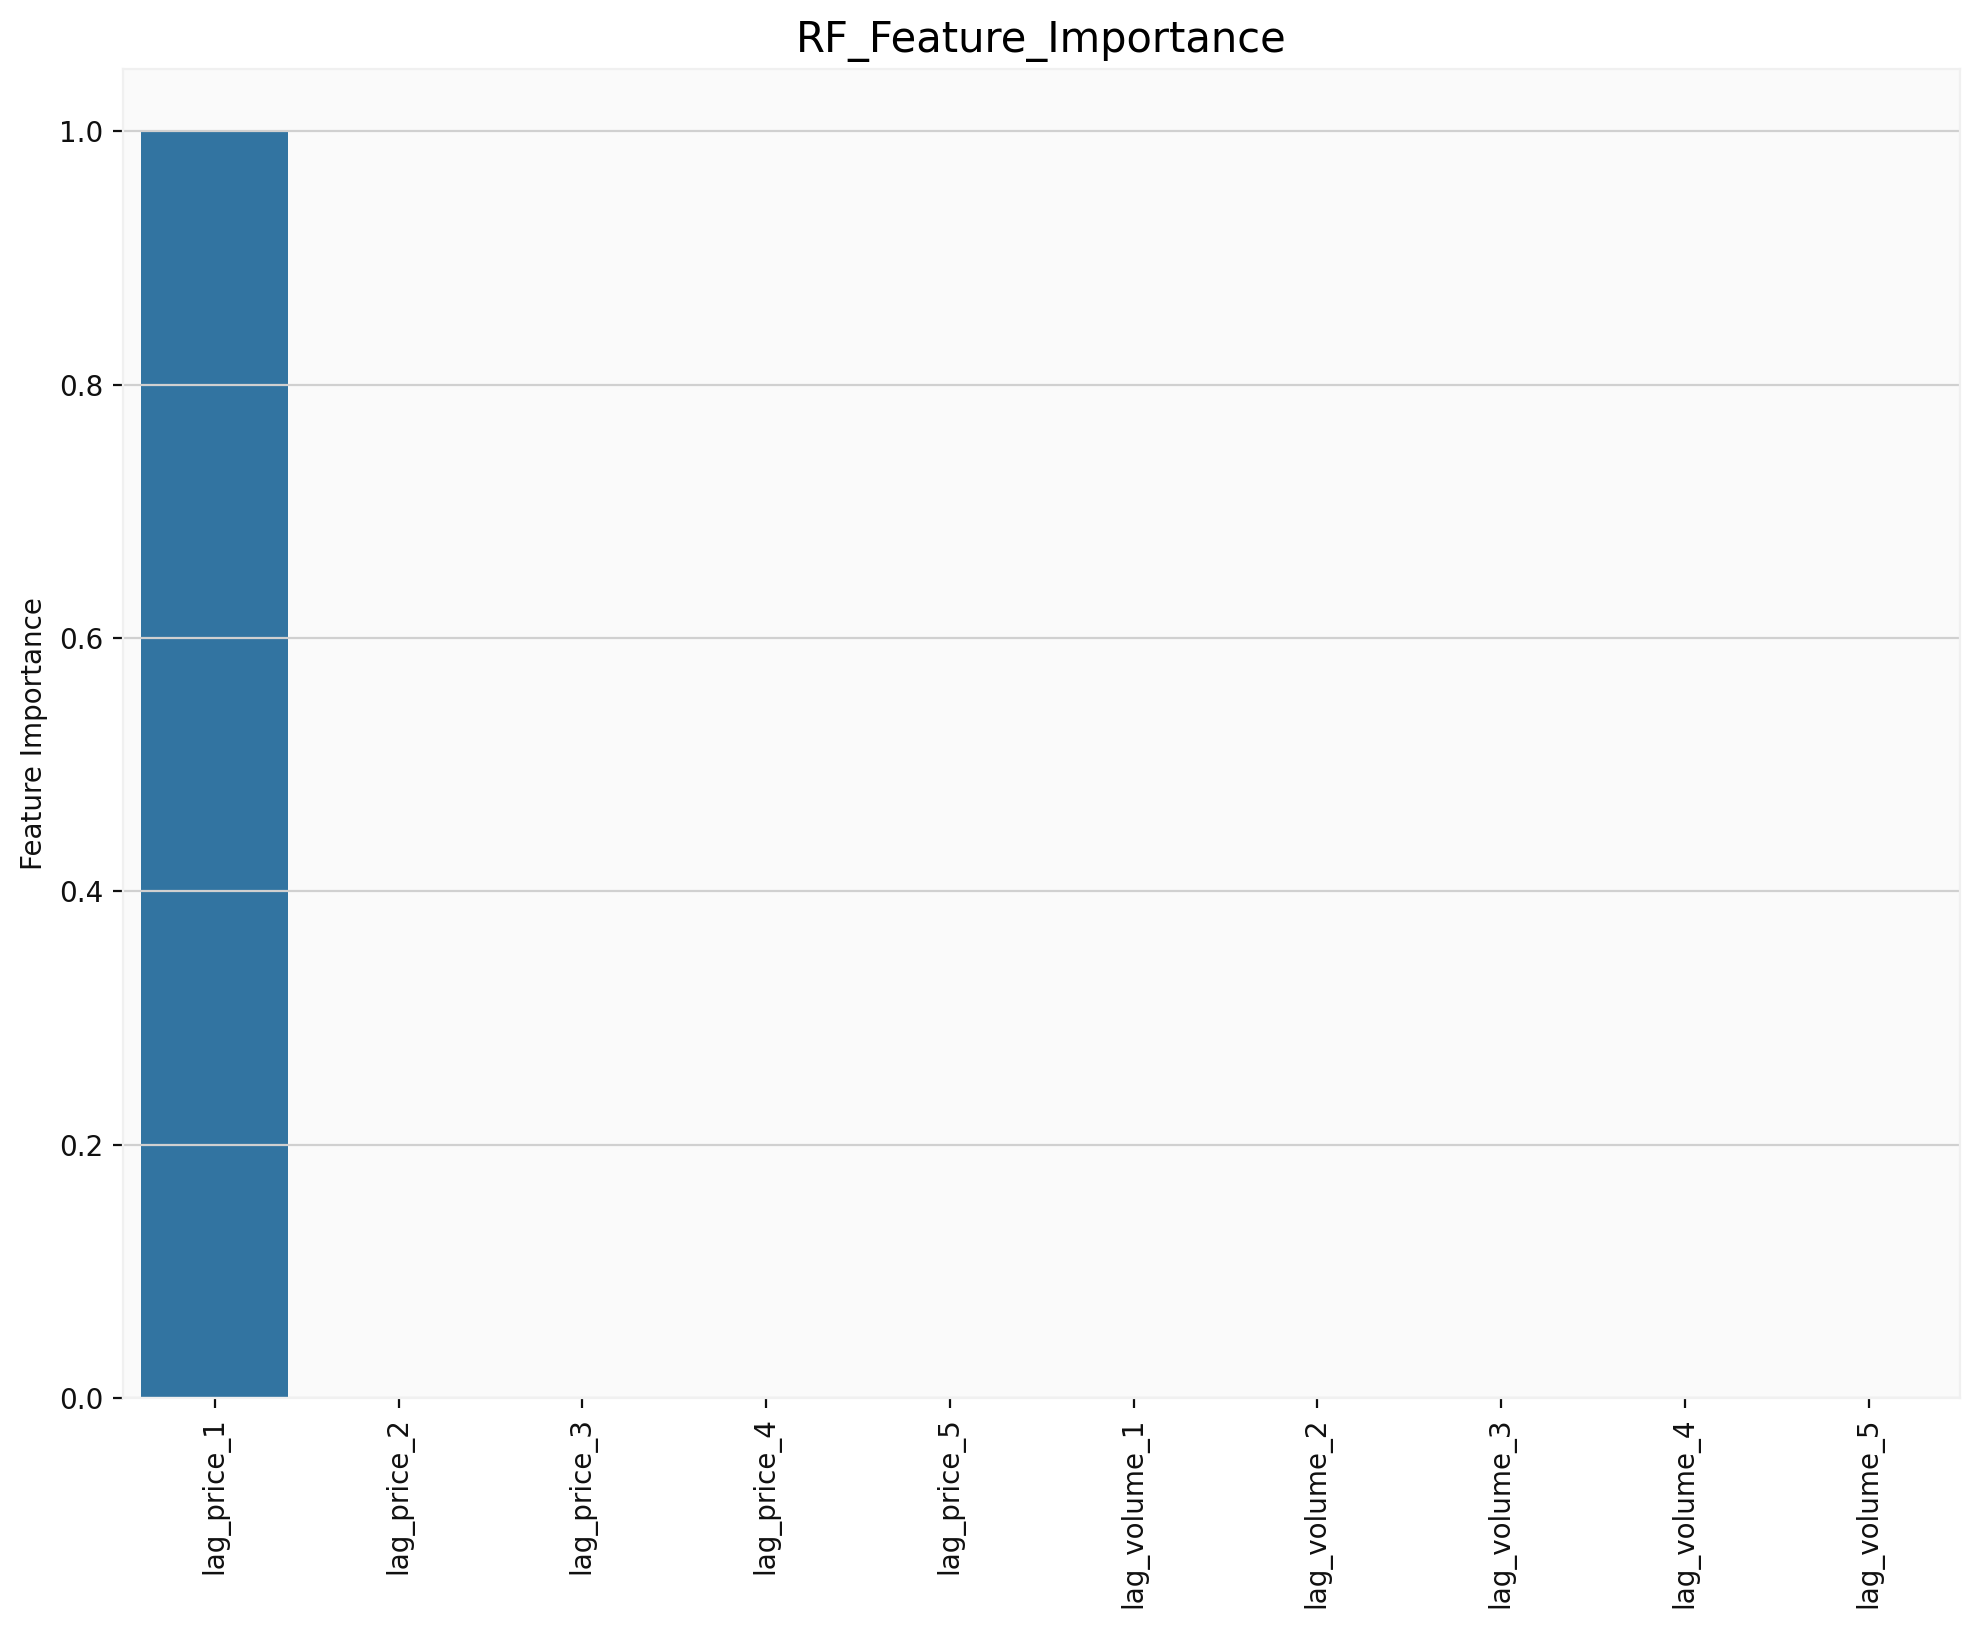

In [ ]:
sns.barplot(x = df_f_i.index, y = 'Feature Importance', data = df_f_i)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.title("RF_Feature_Importance", size=15);

## Prunning

In [ ]:

def report_model(model):
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print('\n')
    print(train_val(model, X_train, y_train, X_test, y_test))
    print('\n')
    '''
    plt.figure(figsize=(12,8),dpi=100)
    plot_tree(model.estimators_[2],filled=True, feature_names=X_train.columns, fontsize=10);
    '''

In [ ]:
pruned_tree = rf_cv_model
#pruned_tree.fit(X_train,y_train)

In [ ]:
report_model(pruned_tree)



         train      test
R2    0.999770  0.802025
mae   0.089428  0.886862
mse   0.019477  4.504281
rmse  0.139558  2.122329




## Prediction

In [ ]:
y_pred_rf = rf_cv_model.predict(X_test)
my_dict = { 'Actual': y_test, 'Pred': y_pred_rf, 'Residual': y_test-y_pred_rf }
compare = pd.DataFrame(my_dict)

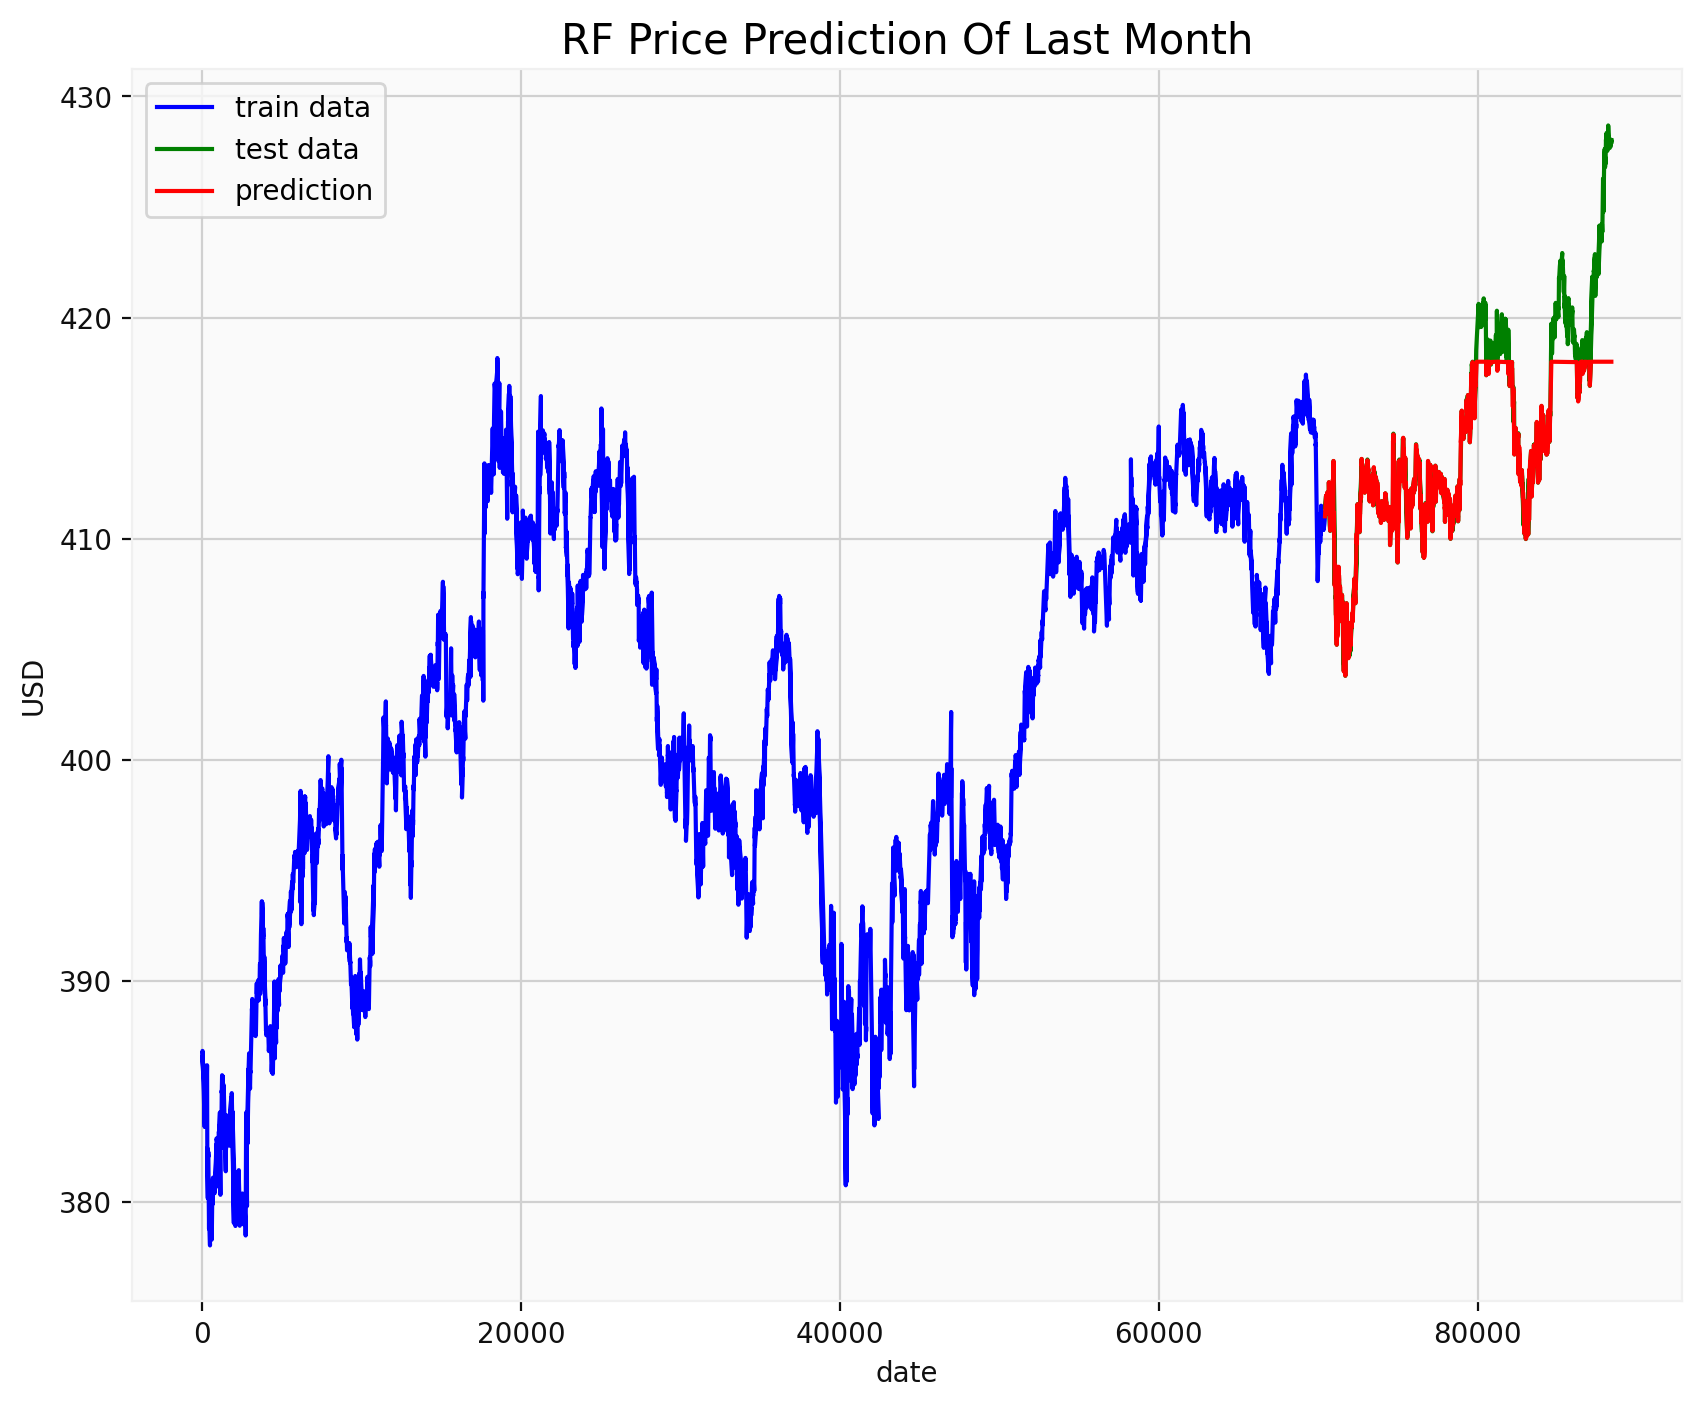

In [ ]:
predicted_prices_rf = df.loc[test_start_index:].copy()
predicted_prices_rf['close'] = y_pred_rf

# Plot train and test data
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = y_train.plot(x='datetime', y='close', style='b-', grid=True)

ax = y_test.plot(x='datetime', y='close', style='g-', grid=True, ax=ax)

ax = predicted_prices_rf['close'].plot(x='datetime', y=predicted_prices_rf['close'], style='r-', grid=True)

ax.legend(['train data', 'test data','prediction'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
plt.title("RF Price Prediction Of Last Month", size=15);

In [ ]:
comp_sample = compare.tail(20)
comp_sample

Actual        Pred   Residual
88357  427.97  417.943209  10.026791
88358  427.95  417.943209  10.006791
88359  427.94  417.943209   9.996791
88360  427.95  417.943209  10.006791
88361  427.91  417.943209   9.966791
88362  427.90  417.943209   9.956791
88363  427.90  417.943209   9.956791
88364  427.90  417.943209   9.956791
88365  427.92  417.943209   9.976791
88366  427.92  417.943209   9.976791
88367  427.94  417.943209   9.996791
88368  427.95  417.943209  10.006791
88369  427.94  417.943209   9.996791
88370  427.97  417.943209  10.026791
88371  427.89  417.943209   9.946791
88372  427.97  417.943209  10.026791
88373  427.95  417.943209  10.006791
88374  427.99  417.943209  10.046791
88375  427.98  417.943209  10.036791
88376  428.03  417.943209  10.086791

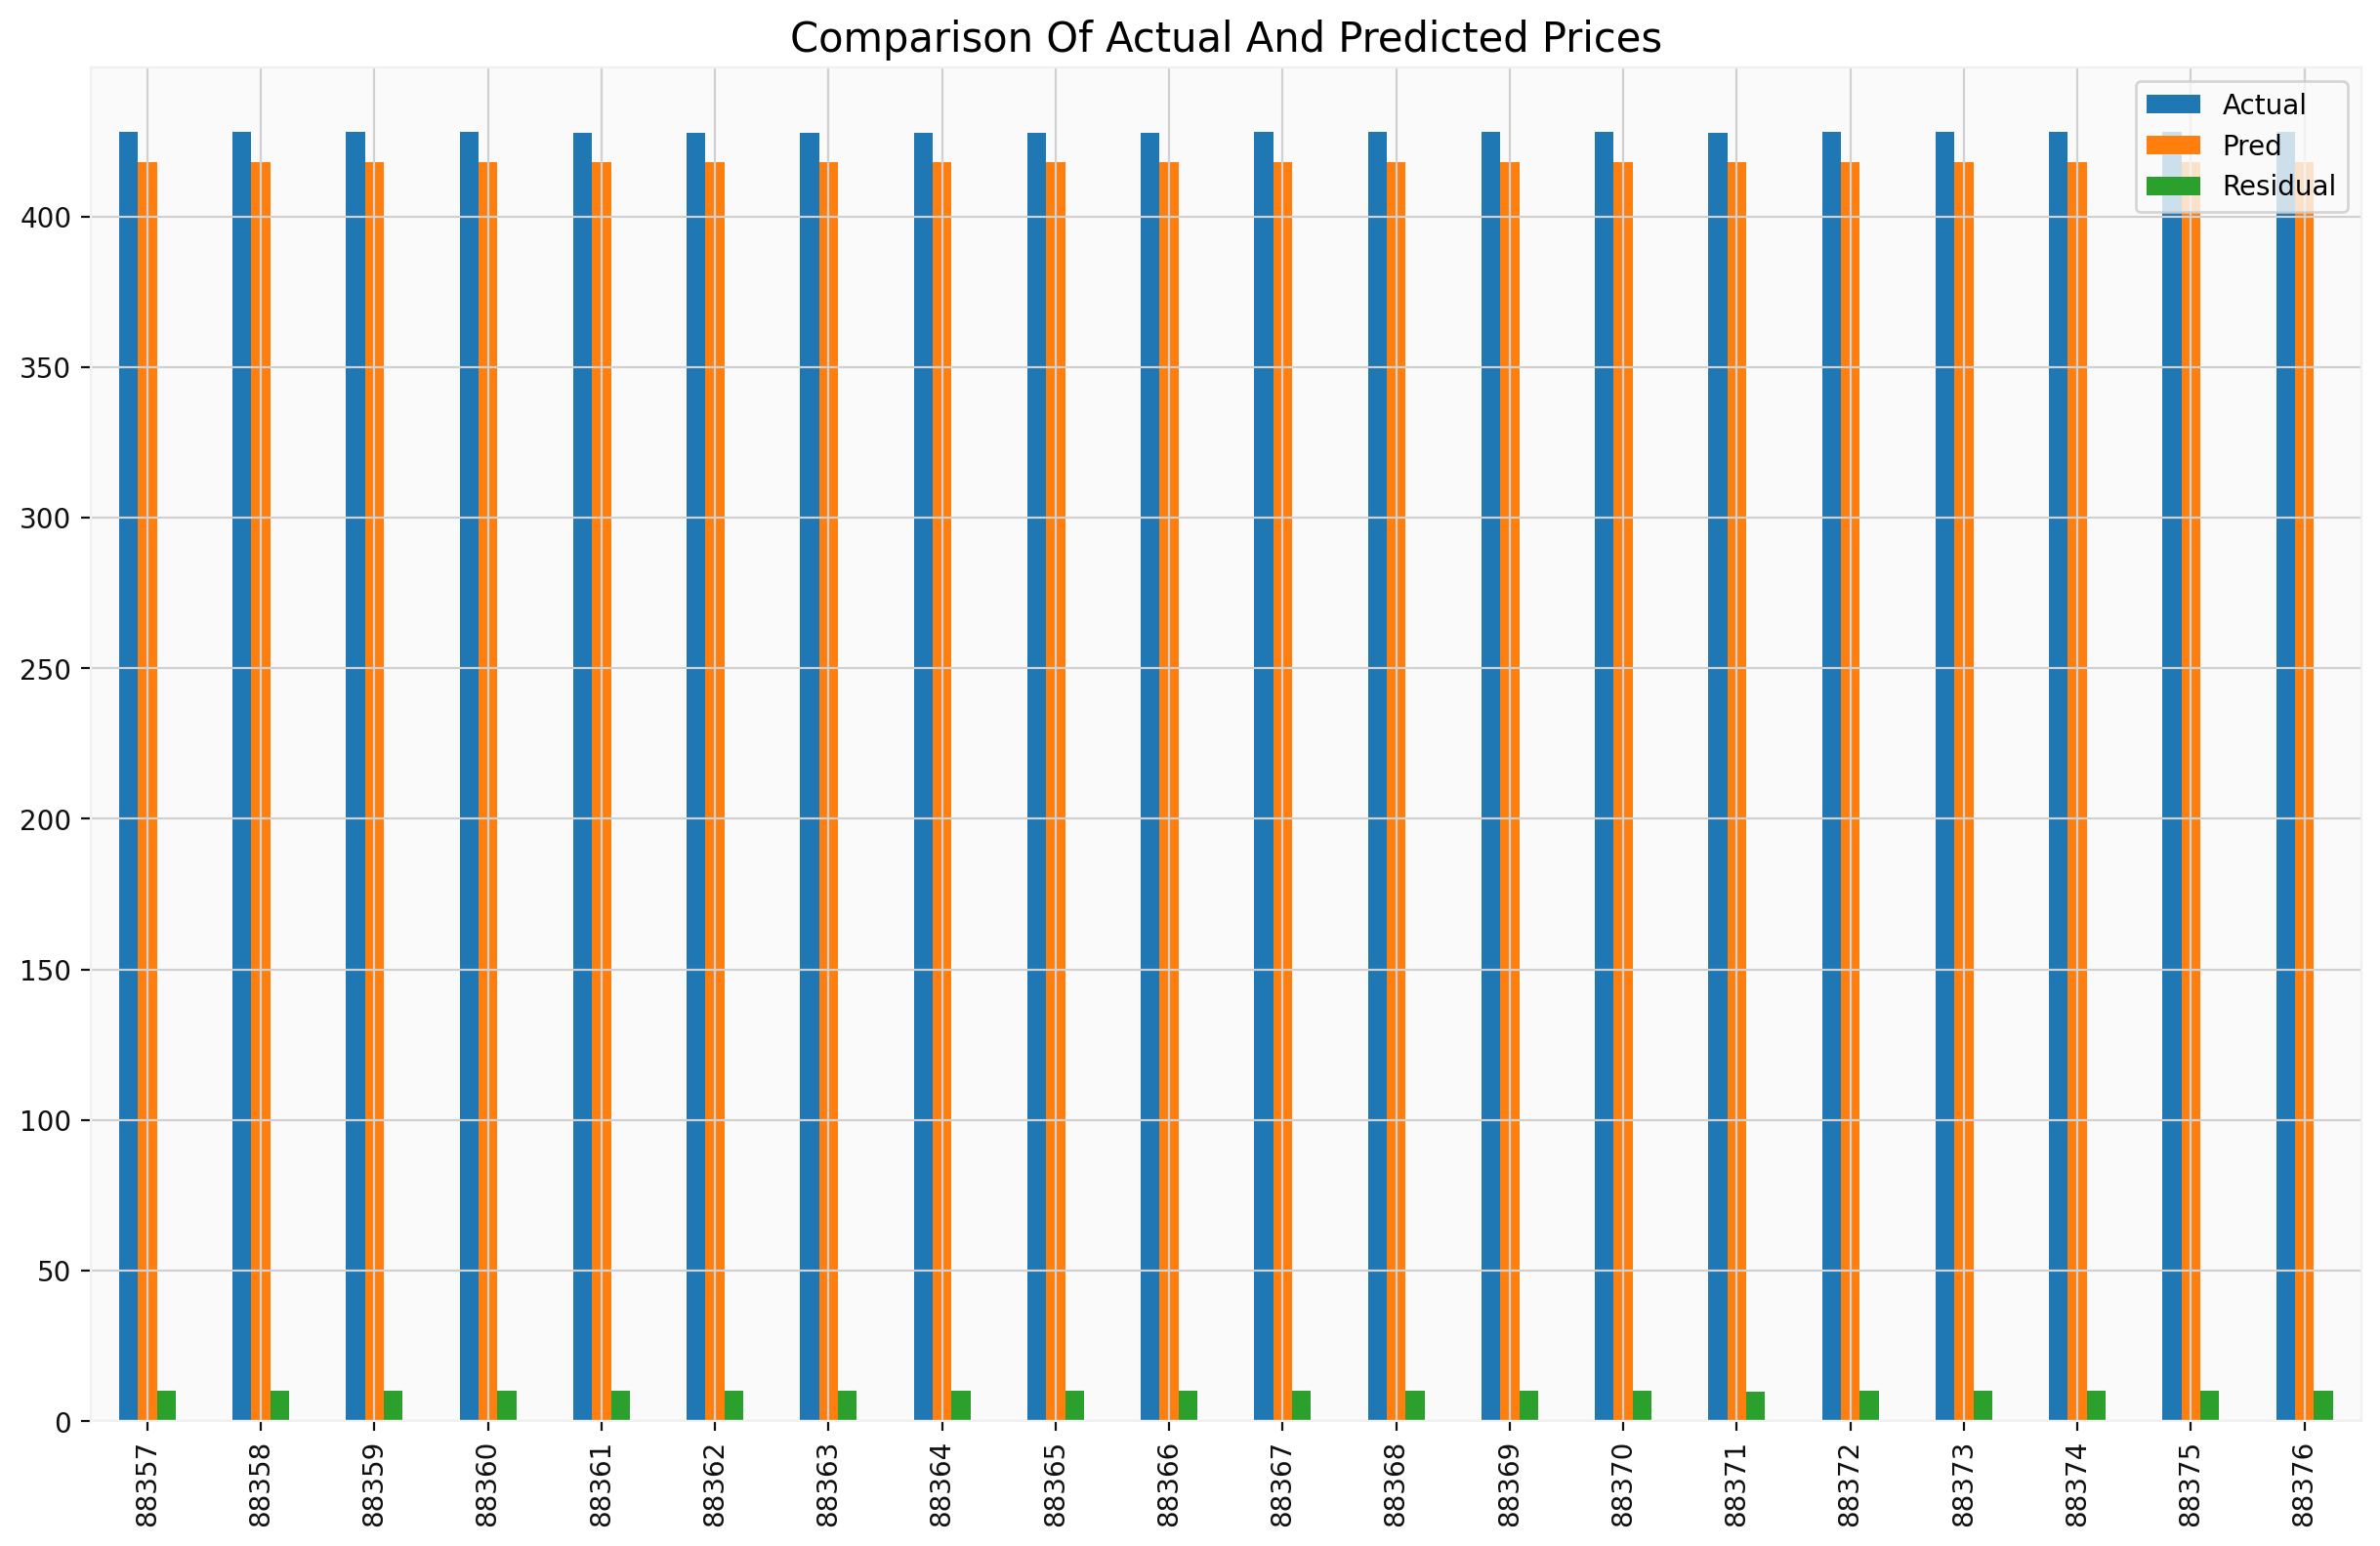

In [ ]:
comp_sample.plot(kind='bar',figsize=(15,9))
plt.title("Comparison Of Actual And Predicted Prices", size=15);

#Prediction with only lag_price_1 and RF

In [ ]:
X_train_lag1 = train_data['lag_price_1']

In [ ]:
X_train_lag1 = X_train_lag1.values.reshape(-1, 1)

In [ ]:
X_test_lag1 = test_data['lag_price_1']

In [ ]:
X_test_lag1 = X_test_lag1.values.reshape(-1, 1)

In [ ]:
lag1_model = RandomForestRegressor( max_depth = 9,
             max_features= 'auto',
             min_samples_leaf = 1,
             min_samples_split= 2,
             n_estimators= 500 , random_state=42)

In [ ]:
lag1_model.fit(X_train_lag1, y_train)

RandomForestRegressor(max_depth=9, max_features='auto', n_estimators=500,
                      random_state=42)

In [ ]:
train_val(lag1_model, X_train_lag1, y_train, X_test_lag1, y_test)

train      test
R2    0.999739  0.806103
mae   0.091712  0.870397
mse   0.022086  4.411501
rmse  0.148615  2.100357

In [ ]:
y_pred_rf = lag1_model.predict(X_test_lag1)


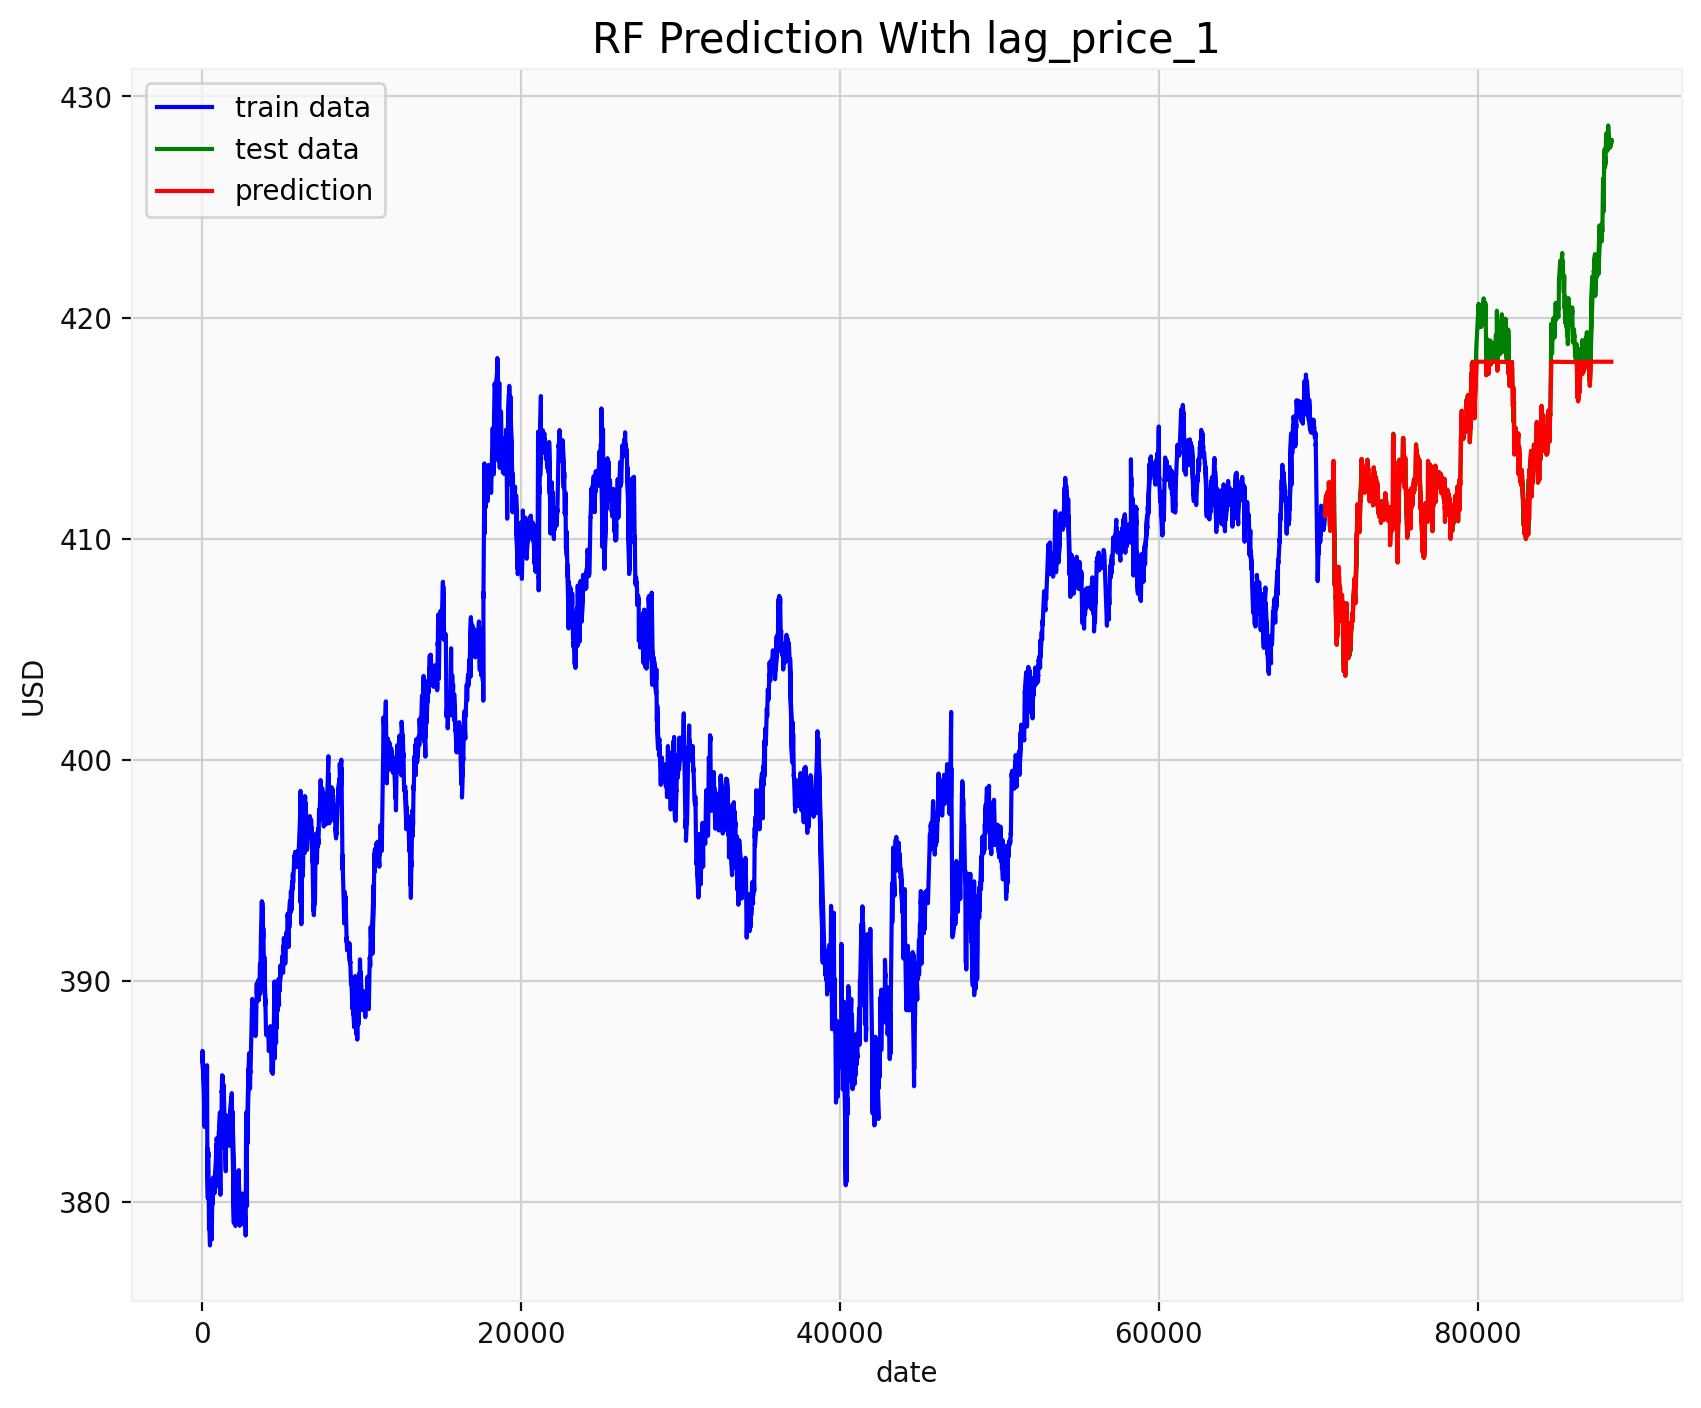

In [ ]:
predicted_prices_rf = df.loc[test_start_index:].copy()
predicted_prices_rf['close'] = y_pred_rf

# Plot train and test data
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = y_train.plot(x='datetime', y='close', style='b-', grid=True)

ax = y_test.plot(x='datetime', y='close', style='g-', grid=True, ax=ax)

ax = predicted_prices_rf['close'].plot(x='datetime', y=predicted_prices_rf['close'], style='r-', grid=True)

ax.legend(['train data', 'test data','prediction'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
plt.title("RF Prediction With lag_price_1", size=15);

# Hyperparameter Tuning With Optuna for RF

In [ ]:
#pip install optuna

In [ ]:
import optuna

In [ ]:
def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 900, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 7),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 7),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }
    
    # Create the Random Forest model with the suggested hyperparameters
    model = RandomForestRegressor(**params)
    
    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    # Get predictions on the validation set
    y_pred = model.predict(X_test)
    
    # Calculate the mean squared error as the objective to minimize
    mse = mean_squared_error(y_test, y_pred)
    
    return mse

In [ ]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2023-06-08 06:33:58,326] A new study created in memory with name: no-name-04835b56-8bbc-4e24-bcdf-80dfea8f47bc
[I 2023-06-08 06:34:24,690] Trial 0 finished with value: 6.665175258173116 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'auto'}. Best is trial 0 with value: 6.665175258173116.
[I 2023-06-08 06:37:54,186] Trial 1 finished with value: 6.658391524530214 and parameters: {'n_estimators': 800, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'auto'}. Best is trial 1 with value: 6.658391524530214.
[I 2023-06-08 06:39:00,771] Trial 2 finished with value: 9.129515295871826 and parameters: {'n_estimators': 900, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 1 with value: 6.658391524530214.
[I 2023-06-08 06:40:00,370] Trial 3 finished with value: 9.071562057172189 and parameters: {'n_estimators': 800, 'max_depth': 5, 'min_samples_

In [ ]:

# Get the best hyperparameters
best_params = study.best_params

# Create the final Random Forest model using the best hyperparameters
final_model = RandomForestRegressor(**best_params)

# Fit the final model on the full training data
final_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = final_model.predict(X_test)


In [ ]:
best_params

{'n_estimators': 300,
 'max_depth': 8,
 'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_features': 'auto'}

In [ ]:
final_model

RandomForestRegressor(max_depth=8, max_features='auto', min_samples_leaf=3,
                      min_samples_split=7, n_estimators=300)

In [ ]:
def train_val(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    scores = {"train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    "test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

In [ ]:
train_val(final_model, X_train, y_train, X_test, y_test)          ## overfitting ?

train      test
R2    0.999738  0.785231
mae   0.092309  0.953915
mse   0.022133  4.886378
rmse  0.148773  2.210515

In [ ]:
from sklearn.model_selection import cross_validate, cross_val_score

scores = cross_validate(final_model, X_train, y_train, scoring=['r2', 
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv =10, return_train_score=True)
df_scores = pd.DataFrame(scores)
df_scores.mean()[2:]

test_r2                              0.996785
train_r2                             0.999736
test_neg_mean_absolute_error        -0.122054
train_neg_mean_absolute_error       -0.092190
test_neg_mean_squared_error         -0.071985
train_neg_mean_squared_error        -0.022014
test_neg_root_mean_squared_error    -0.206032
train_neg_root_mean_squared_error   -0.148330
dtype: float64

# Conclusion

After performing some initial preprocessing, including cleaning the dataset, I applied XGBoost and Random Forest models, incorporating cross-validation and grid search techniques. The test data for evaluation consisted of the prices from the previous month. However, it appears that there is evidence of overfitting in the models.

In an attempt to address the overfitting issue, I employed another approach by utilizing hyperparameter tuning with Optuna. Unfortunately, even with this method, the results did not show any significant improvement. This suggests the possibility that the features used to train the model may not be suitable for effectively explaining the fluctuations in price.

I have provided answers to all five questions in the task.

Please let me know if you require any further clarification or if there are any additional tasks I can assist you with.